# EDA: Crime Data from 2020 to Present
LAPD Data: Understand schema, data quality, and core patterns over time, space, and offense types.  
Data source: City of Los Angeles Open Data — “Crime Data from 2020 to Present”.

Source: https://catalog.data.gov/dataset/crime-data-from-2020-to-present 

Description: 
> Our dataset is published by Los Angeles Police Department (LAPD) and contains all reported crime incidents for the city of Los Angeles from January 1, 2020 to May 29, 2025. It contains 1,004,991 rows and 28 columns and is updated on a bimonthly basis (LAPD Open Data). Each crime incident includes detailed information such as the date and time of the crime with hour-minute precision, victim demographics (age, gender and ethnicity), crime scene location type (e.g. house, car, or garage), the closest street, cross-street, latitude and longitude, and area name. The city is divided into 21 geographic areas based on the 21 Los Angeles Community Police Stations. Each record also specifies the type of crime, whether a weapon was used, and, if so, the type of weapon. The LAPD uses standardized codes for crime types, weapons, and locations, and each code is accompanied by a description for clarity.

**Question**: *Can we use crime data, such as location and time to predict whether a crime is violent?*

## Setup & Data Sources

In [1]:
import warnings

import numpy as np
import pandas as pd
from collections import Counter


import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
from matplotlib.ticker import FuncFormatter
from pyproj import Transformer

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid", palette="tab10")

In [2]:
df = pd.read_csv("./data/Crime_Data_from_2020_to_Present.csv")
df_pop = pd.read_csv("./data/raw/ACSDT5Y2023.B01003-Data.csv")

### Data Source Notes
- `Crime_Data_from_2020_to_Present.csv`: LAPD incident-level feed with >1M rows, refreshed biweekly; includes timestamps, locations, victim demographics, and coded descriptors for crime, weapon, and premises.
- `ACSDT5Y2023.B01003-Data.csv`: 5-year ACS (table B01003) population counts that will support per-capita rate calculations by area.

In [3]:
# helper functions
biweekly_note = pd.Timestamp("2024-01-18") # database cadence shift
rms_date = pd.Timestamp("2024-03-07")  # Database phase-out date from LAPD open data notes

def add_event_marker(ax, event, **line_kwargs):
    """Add an optional vertical marker to a matplotlib Axes."""
    if event is None:
        return
    if hasattr(event, "to_timestamp"):
        event = event.to_timestamp()
    ax.axvline(event, **line_kwargs)


## Data Cleaning & Feature Engineering


### Schema Audit & Column Standardization

In [4]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [5]:
new_names = {
    "DR_NO": "id",
    "Date Rptd": "date_reported",
    "DATE OCC": "date_occurred",
    "TIME OCC": "time_occurred",
    "AREA": "area_code",
    "AREA NAME": "area_name",
    "Rpt Dist No": "sub_area_code",
    "Part 1-2": "crime_severity_code",
    "Crm Cd": "crime_code",
    "Crm Cd Desc": "crime_desc",
    "Mocodes": "suspect_modus_code",
    "Vict Age": "victim_age",
    "Vict Sex": "victim_sex",
    "Vict Descent": "victim_descent",
    "Premis Cd": "location_type_code",
    "Premis Desc": "location_type_desc",
    "Weapon Used Cd": "weapon_code",
    "Weapon Desc": "weapon_desc",
    "Status": "crime_status_code",
    "Status Desc": "crime_status_desc",
    "Crm Cd 1": "crime_code_1",
    "Crm Cd 2": "crime_code_2",
    "Crm Cd 3": "crime_code_3",
    "Crm Cd 4": "crime_code_4",
    "LOCATION": "crime_street",
    "Cross Street": "crime_cross_street",
    "LAT": "lat",
    "LON": "long",
}

df = df.rename(columns=new_names)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1004991 non-null  int64  
 1   date_reported        1004991 non-null  object 
 2   date_occurred        1004991 non-null  object 
 3   time_occurred        1004991 non-null  int64  
 4   area_code            1004991 non-null  int64  
 5   area_name            1004991 non-null  object 
 6   sub_area_code        1004991 non-null  int64  
 7   crime_severity_code  1004991 non-null  int64  
 8   crime_code           1004991 non-null  int64  
 9   crime_desc           1004991 non-null  object 
 10  suspect_modus_code   853372 non-null   object 
 11  victim_age           1004991 non-null  int64  
 12  victim_sex           860347 non-null   object 
 13  victim_descent       860335 non-null   object 
 14  location_type_code   1004975 non-null  float64
 15

In [7]:
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")
df.sample(5, random_state=0)

Rows: 1,004,991, Columns: 28


,id,date_reported,date_occurred,time_occurred,area_code,area_name,sub_area_code,crime_severity_code,crime_code,crime_desc,suspect_modus_code,victim_age,victim_sex,victim_descent,location_type_code,location_type_desc,weapon_code,weapon_desc,crime_status_code,crime_status_desc,crime_code_1,crime_code_2,crime_code_3,crime_code_4,crime_street,crime_cross_street,lat,long
281720,210619791,11/29/2021 12:00:00 AM,11/27/2021 12:00:00 AM,1800,6,Hollywood,648,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),1300 1822 1601 1606 0344 0352,26,F,W,123.0,PARKING UNDERGROUND/BUILDING,NaN,NaN,IC,Invest Cont,420.0,NaN,NaN,NaN,5600 CARLTON WY,NaN,34.1005,-118.3136
951827,241306695,02/26/2024 12:00:00 AM,02/21/2024 12:00:00 AM,2036,13,Newton,1363,1,310,BURGLARY,1607 0344,0,M,W,729.0,SPECIALTY SCHOOL/OTHER,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,310.0,NaN,NaN,NaN,800 E 48TH ST,NaN,33.9997,-118.2612
708761,231312169,06/11/2023 12:00:00 AM,06/11/2023 12:00:00 AM,1250,13,Newton,1321,1,310,BURGLARY,0344 0329 1607 0314,21,F,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,310.0,NaN,NaN,NaN,300 W ADAMS BL,NaN,34.0289,-118.2686
557364,221906916,03/13/2022 12:00:00 AM,03/13/2022 12:00:00 AM,1638,19,Mission,1921,1,210,ROBBERY,0341 0405 1227 0344 0334 1402 1822 0302 1310,22,M,B,101.0,STREET,109.0,SEMI-AUTOMATIC PISTOL,IC,Invest Cont,210.0,910.0,998.0,NaN,15200 NURMI ST,NaN,34.2966,-118.4644
583709,221911878,07/12/2022 12:00:00 AM,07/11/2022 12:00:00 AM,1730,19,Mission,1981,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,8400 LANGDON AV,NaN,34.2231,-118.4699


In [8]:
print(df.dtypes.value_counts())

object     13
float64     8
int64       7
Name: count, dtype: int64


### Parse Dates & Derive Features


In [9]:
df["date_reported"] = pd.to_datetime(df["date_reported"], errors="coerce")
df['date_occurred'] = pd.to_datetime(df['date_occurred'], errors='coerce')
df["time_occurred"] = df["time_occurred"].astype("Int64")

# mark impossible HHMM values as <NA> (e.g. 2460, 9999)
valid_clock = df["time_occurred"].between(0, 2359) & (df["time_occurred"] % 100 < 60)
df.loc[~valid_clock, "time_occurred"] = pd.NA

df["hour"]   = (df["time_occurred"] // 100).astype("Int64") # split into hour / minute
df["minute"] = (df["time_occurred"]  % 100).astype("Int64")

# merging into single timestamp column (date + hh:mm)
df["timestamp_occurred"] = (
    df["date_occurred"]
    + pd.to_timedelta(df["hour"].fillna(0),   unit="h")
    + pd.to_timedelta(df["minute"].fillna(0), unit="m")
)
df.head(5)[["date_reported", "date_occurred", "time_occurred", "hour", "minute", "timestamp_occurred"]] # verify timestamp merge
df["weekday"] = df["timestamp_occurred"].dt.day_name()
df["month"]   = df["timestamp_occurred"].dt.month_name()
df["year"]    = df["timestamp_occurred"].dt.year.astype("Int64")
df["is_weekend"] = df["weekday"].isin(["Saturday", "Sunday"])

In [10]:
# FOR PLOTTING TEST DATA MAP 
# start = pd.Timestamp('2020-04-01')
# end   = pd.Timestamp('2022-06-01')
# df = df[(df["timestamp_occurred"] >= start) & (df["timestamp_occurred"] < end)]
# print(("Start and end of training data: ", df["timestamp_occurred"].min(), df["timestamp_occurred"].max()))

### Missing Data Profile


In [11]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_percentages = (df.isnull().sum() / len(df)) * 100

# filter for columns with more than 1 missing value
columns_with_multiple_missing = missing_counts[missing_counts > 1].index
filtered_missing_counts = missing_counts[columns_with_multiple_missing]
filtered_missing_percentages = missing_percentages[columns_with_multiple_missing]

missing_info = pd.DataFrame({
    'Missing Count': filtered_missing_counts,
    'Missing Percentage': filtered_missing_percentages
})

print("Missing count and percentage per column (with more than 1 missing value):")
print(missing_info)

Missing count and percentage per column (with more than 1 missing value):
                    Missing Count  Missing Percentage
crime_code_4              1004927           99.993632
crime_code_3              1002677           99.769749
crime_code_2               935831           93.118346
crime_cross_street         850755           84.652997
weapon_desc                677744           67.437818
weapon_code                677744           67.437818
suspect_modus_code         151619           15.086603
victim_descent             144656           14.393761
victim_sex                 144644           14.392567
location_type_desc            588            0.058508
location_type_code             16            0.001592
crime_code_1                   11            0.001095


In [12]:
cols_to_drop = [
    "crime_code_1", "crime_code_2", "crime_code_3", "crime_code_4",
    "crime_cross_street", "crime_status_code", "crime_status_desc",
    "suspect_modus_code", "sub_area_code", "date_occurred", "minute", "crime_severity_code",
]
existing = [col for col in cols_to_drop if col in df.columns]
if existing:
    df = df.drop(columns=existing)
    print(f"Dropped {len(existing)} columns with limited coverage: {existing}")
else:
    print("No high-missing columns to drop in this extract.")

Dropped 12 columns with limited coverage: ['crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4', 'crime_cross_street', 'crime_status_code', 'crime_status_desc', 'suspect_modus_code', 'sub_area_code', 'date_occurred', 'minute', 'crime_severity_code']


In [13]:
# pair missing code description to codes
def make_desc_map(df, code_col, desc_col):
    s = df.dropna(subset=[code_col, desc_col]).copy()
    s[code_col] = pd.to_numeric(s[code_col], errors='coerce').astype('Int64') # normalize types
    s[desc_col] = s[desc_col].astype(str).str.strip()
    mode = (s.groupby(code_col)[desc_col] # choose the most frequent description per code (mode)
              .agg(lambda x: x.mode().iat[0] if not x.mode().empty else pd.NA))
    return mode.to_dict()

# code -> desc map only from complete pairs
loc_map = make_desc_map(df, 'location_type_code', 'location_type_desc')
weap_map = make_desc_map(df, 'weapon_code', 'weapon_desc')
crime_map = make_desc_map(df, 'crime_code', 'crime_desc')

# vectorized backfill of missing descriptions
df['location_type_code']  = pd.to_numeric(df['location_type_code'], errors='coerce').astype('Int64')
df['location_type_desc']  = df['location_type_desc'].where(
    df['location_type_desc'].notna(),
    df['location_type_code'].map(loc_map)
)

# check coverage
still_missing = df.loc[df['location_type_code'].notna() & df['location_type_desc'].isna(),
                       'location_type_code'].unique()
print("Codes still without a description:", still_missing)
missing_keys = set(still_missing) - set(pd.Series(loc_map).index)
print("Not in loc_map at all:", missing_keys)

Codes still without a description: <IntegerArray>
[418, 256, 974, 972, 973, 976, 975]
Length: 7, dtype: Int64
Not in loc_map at all: {256, 418, 972, 973, 974, 975, 976}


In [ ]:
df["weapon_code"] = pd.to_numeric(df["weapon_code"], errors="coerce").astype("Int64")
df["weapon_desc"] = df["weapon_desc"].fillna("NO WEAPON")
df["weapon_involved"] = df["weapon_code"].notna().astype(int)

# tagging violent crimes according to analysis
violent_crimes = [
    "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT",
    "INTIMATE PARTNER - SIMPLE ASSAULT",
    "ROBBERY",
    "CRIMINAL HOMICIDE",
    "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",
    "RAPE, FORCIBLE",
    "MANSLAUGHTER, NEGLIGENT",
    "BATTERY - SIMPLE ASSAULT",
    "LYNCHING",
]
df["crime_type"] = np.where(
    (df["weapon_involved"] == 1) | df["crime_desc"].isin(violent_crimes),
    "Violent",
    "Non-Violent",
)
df["violent_crime"] = (df["crime_type"] == "Violent").astype(int)
cols_to_show = ["crime_desc","weapon_code","weapon_desc", "weapon_involved","crime_type","violent_crime"]
df[cols_to_show].head(2)

,crime_desc,weapon_code,weapon_desc,weapon_involved,crime_type,violent_crime
0,THEFT OF IDENTITY,<NA>,NO WEAPON,0,Non-Violent,0
1,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",200,KNIFE WITH BLADE 6INCHES OR LESS,1,Violent,1


In [ ]:
df["violent_crime"] = (
    df["crime_type"]
      .astype(str).str.strip().str.casefold()
      .map({"violent": 1, "non-violent": 0})
      .fillna(0) 
      .astype(int)
)

# sanity check
print(df["crime_type"].value_counts(dropna=False))
print(df["violent_crime"].value_counts())

crime_type
Non-Violent    677606
Violent        327385
Name: count, dtype: int64
violent_crime
0    677606
1    327385
Name: count, dtype: int64


In [16]:
# 	F - Female M - Male X - Unknown
df["victim_sex"]=df["victim_sex"].str.upper().map({"M":"M","MALE":"M","F":"F","FEMALE":"F","X":"X","UNKNOWN":"X"}).fillna("X")

descent_map = {"A":"Other Asian","B":"Black","C":"Chinese","D":"Cambodian","F":"Filipino","G":"Guamanian",
               "H":"Hispanic","I":"Native American","J":"Japanese","K":"Korean","L":"Laotian","O":"Other",
               "P":"Pacific Islander","S":"Samoan","U":"Hawaiian","V":"Vietnamese","W":"White","X":"Unknown","Z":"Asian Indian"
}

df["victim_descent"] = df["victim_descent"].astype(str).str.strip().str.upper().map(descent_map).fillna("Unknown")
print(df["victim_sex"].value_counts(dropna=False))
print(df["victim_descent"].value_counts(dropna=False))

victim_sex
M    403879
F    358580
X    242532
Name: count, dtype: int64
victim_descent
Hispanic            296404
Unknown             251343
White               201442
Black               135816
Other                78005
Other Asian          21340
Korean                5990
Filipino              4838
Chinese               4631
Japanese              1586
Vietnamese            1195
Native American       1015
Asian Indian           577
Pacific Islander       288
Hawaiian               221
Cambodian               91
Laotian                 77
Guamanian               74
Samoan                  58
Name: count, dtype: int64


In [17]:
# redo missing summary after cleaning
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_percentages = (df.isnull().sum() / len(df)) * 100

columns_with_multiple_missing = missing_counts[missing_counts > 1].index
filtered_missing_counts = missing_counts[columns_with_multiple_missing]
filtered_missing_percentages = missing_percentages[columns_with_multiple_missing]

missing_info = pd.DataFrame({
    'Missing Count': filtered_missing_counts,
    'Missing Percentage': filtered_missing_percentages
})
print("Exact duplicates:", df.duplicated().sum())
print("Missing count and percentage per column (with more than 1 missing value):")
print(missing_info)

Exact duplicates: 0
Missing count and percentage per column (with more than 1 missing value):
                    Missing Count  Missing Percentage
weapon_code                677744           67.437818
location_type_desc            588            0.058508
location_type_code             16            0.001592


### Geospatial Feature Engineering


In [18]:
# Filter out invalid latitude/longitude pairs (0, 0 is the LAPD missing code)
df = df[~((df['lat'] == 0) & (df['long'] == 0))]

In [19]:
zctas = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/tl_2023_us_zcta520.zip"
)[["ZCTA5CE20", "geometry"]].rename(columns={"ZCTA5CE20": "zip"})

In [20]:
# points = gpd.GeoDataFrame(
#     df, geometry=gpd.points_from_xy(df["long"], df["lat"]),
#     crs="EPSG:4326"
# )

points = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["long"], df["lat"]),
    crs=4326
).to_crs(3857)

In [21]:
zctas = zctas.to_crs(points.crs) # polygons and points must share the same CRS

In [22]:
# Spatial join assigns each point a ZIP
# "within" is strict; if some points are just outside edges, fall back to sjoin_nearest with a small tolerance
try:
    points_zip = gpd.sjoin(points, zctas, how="left", predicate="within").drop(columns=["index_right"])
except Exception:
    points_zip = gpd.sjoin_nearest(points, zctas, how="left", max_distance=150)  # meters

points_zip["zip"] = points_zip["zip"].astype(str).str.zfill(5) # Clean the key

In [23]:
# points_zip = gpd.sjoin(points, zctas[["zip","geometry"]], how="left", predicate="within") # points → ZIP
# points_zip["zip"] = points_zip["zip"].astype(str).str.zfill(5) # ensure keys are clean

# make sure violent_crime is numeric 0/1
points_zip["violent_crime"] = (
    points_zip["violent_crime"].astype(int)  # or map from boolean/text if needed
)

# totals per ZIP
totals_zip = (points_zip
    .dropna(subset=["zip"])
    .groupby("zip", as_index=False)
    .agg(crime_violent=("violent_crime","sum"))
)

In [24]:
print(points.crs, zctas.crs)
print(points_zip.shape, points_zip["zip"].notna().sum())
print(totals_zip.shape, totals_zip["crime_violent"].sum())

EPSG:3857 EPSG:3857
(1002751, 28) 1002751
(151, 2) 326552


In [25]:
la_boundary = gpd.read_file("./data/City_Boundary/City_Boundary.shp").to_crs(3857)
points = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["long"], df["lat"]),
    crs=4326
).to_crs(3857)
print(la_boundary.crs, points.crs)
print(la_boundary.total_bounds, points.total_bounds)

EPSG:3857 EPSG:3857
[-13210082.3167002    3989079.29699635 -13152995.60809683
   4074185.09203552] [-13210016.80565987   3989379.61470414 -13152998.96247556
   4073779.16609061]


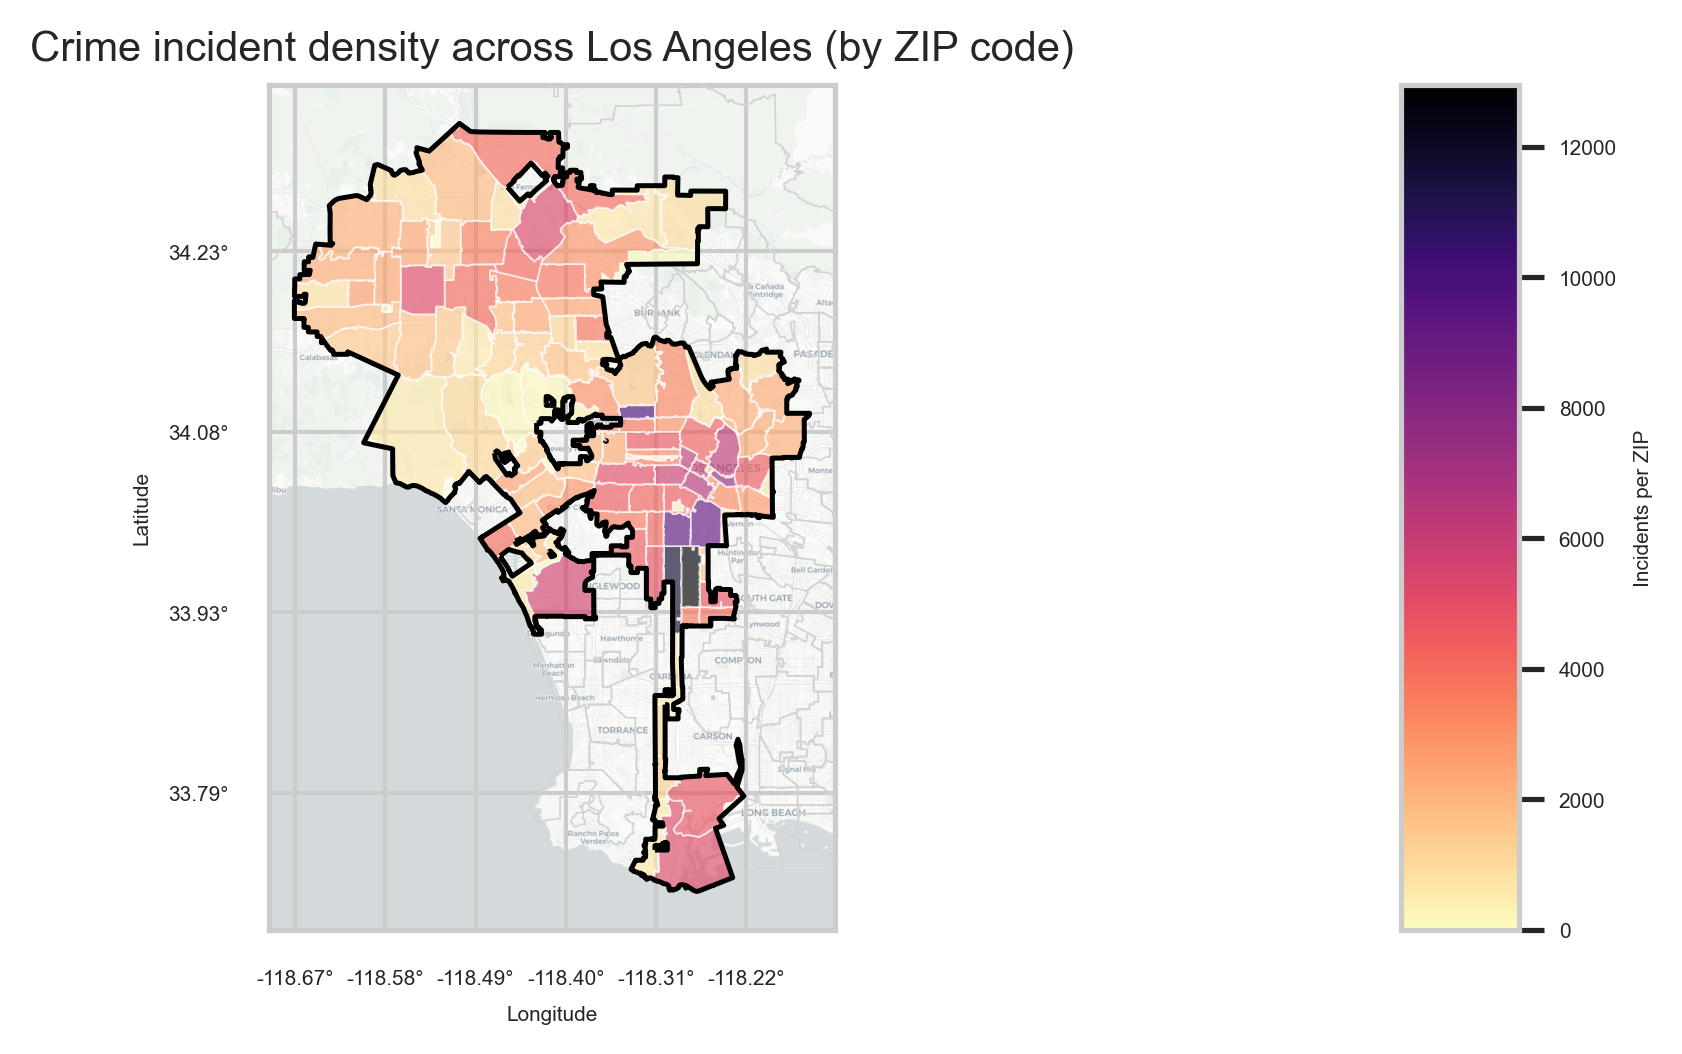

In [26]:
# --- prep: polygons with data, in Web Mercator ---
choropleth = zctas.merge(totals_zip, on="zip", how="left").to_crs(3857)
la_boundary_3857 = la_boundary.to_crs(3857)

# NEW: speed up spatial ops and compute inside/outside once
la_geom = la_boundary_3857.unary_union
choropleth["inside_la"] = choropleth.geometry.intersects(la_geom)

# NEW: display geometry = clipped to LA (values still per ZIP)
import geopandas as gpd
choropleth_in_disp  = gpd.clip(choropleth[choropleth["inside_la"]], la_boundary_3857)  # fill
choropleth_out_line = choropleth[~choropleth["inside_la"]]                              # outline only

# Map extent from the city boundary (or from choropleth.total_bounds)
xmin, ymin, xmax, ymax = la_boundary_3857.total_bounds
padx, pady = (xmax-xmin)*0.05, (ymax-ymin)*0.05
extent = (xmin-padx, xmax+padx, ymin-pady, ymax+pady)

# --- figure: wider than tall + reserved colorbar column ---
W, H, DPI = 6.5, 3.4, 300
fig = plt.figure(figsize=(W, H), dpi=DPI, layout="constrained")
gs  = fig.add_gridspec(1, 30)
ax  = fig.add_subplot(gs[0, :28])   # main map
cax = fig.add_subplot(gs[0, 28:])   # colorbar

# set extent BEFORE basemap
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

try:
    cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.CartoDB.Positron, zoom=11, attribution="")
except Exception:
    cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, zoom=11)

# city outline (on top)
la_boundary_3857.dissolve().boundary.plot(ax=ax, edgecolor="black", linewidth=1.2, zorder=9)

# NEW: draw outside ZIPs as outlines only (so the map looks less “covered”)
choropleth_out_line.boundary.plot(ax=ax, color="lightgray", linewidth=0.4, zorder=5)

# --- ZIP choropleth (now visually clipped to LA) ---
metric = "crime_violent"

# NEW: compute color scale from in-scope values only
import numpy as np, matplotlib as mpl
vals = choropleth_in_disp[metric].to_numpy(dtype=float)
vmin, vmax = np.nanmin(vals), np.nanmax(vals)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.get_cmap("magma_r")

choropleth_in_disp.plot(
    ax=ax, column=metric, cmap=cmap, norm=norm,
    edgecolor="white", linewidth=0.45,
    alpha=0.65,    # less transparency now that we clipped
    legend=False, zorder=8
)

to_ll = Transformer.from_crs(3857, 4326, always_xy=True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _ : f"{to_ll.transform(x, extent[2])[0]:.2f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _ : f"{to_ll.transform(extent[0], y)[1]:.2f}°"))
ax.set_title("Crime incident density across Los Angeles (by ZIP code)", fontsize=10)
ax.set_xlabel("Longitude", fontsize=5); ax.set_ylabel("Latitude", fontsize=5)
ax.tick_params(labelsize=5)
ax.set_aspect("equal", adjustable="box")
sm   = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cb   = fig.colorbar(sm, cax=cax)
cb.set_label("Incidents per ZIP" if metric=="crime_violent" else "Incidents per 100k", fontsize=5)
cax.tick_params(labelsize=5)

plt.savefig("./figures/la_zip_map_full.png", dpi=DPI, bbox_inches="tight", facecolor="white")
plt.show()

In [27]:
choropleth.to_parquet("./data/la_choropleth_3857.parquet")

In [28]:
# la_boundary = gpd.read_file("./data/City_Boundary/City_Boundary.shp").to_crs(3857)
# points = gpd.GeoDataFrame(
#     df.copy(),
#     geometry=gpd.points_from_xy(df["long"], df["lat"]),
#     crs=4326
# ).to_crs(3857)

# # Clip to city (optional but tidy)
# points = gpd.sjoin(points, la_boundary[["geometry"]], predicate="within", how="inner")

# # Map extent from the boundary
# xmin, ymin, xmax, ymax = la_boundary.total_bounds
# padx, pady = (xmax - xmin) * 0.05, (ymax - ymin) * 0.05
# extent = (xmin - padx, xmax + padx, ymin - pady, ymax + pady)

# fig, ax = plt.subplots(figsize=(14, 6)) 

# # 1) Set extent FIRST (so contextily knows what to fetch)
# ax.set_xlim(extent[0], extent[1])
# ax.set_ylim(extent[2], extent[3])

# # 2) Basemap (labels + water)
# try:
#     cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.CartoDB.Voyager)
# except Exception:
#     cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik)

# # 3) City outline
# la_boundary.dissolve().boundary.plot(ax=ax, edgecolor="white", linewidth=1.4, zorder=5)


# # 4) Hexbin on top (use same extent)
# hb = ax.hexbin(
#     points.geometry.x, points.geometry.y,
#     gridsize=80, mincnt=5,
#     cmap="magma",
#     extent=extent,
#     edgecolors="none",   
#     linewidths=0,       
#     alpha=0.5,          
#     zorder=6
# )

# to_ll = Transformer.from_crs(3857, 4326, always_xy=True)
# ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _ : f"{to_ll.transform(x, extent[2])[0]:.2f}°"))
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _ : f"{to_ll.transform(extent[0], y)[1]:.2f}°"))
# fig.colorbar(hb, ax=ax, label="Incidents per hex")
# ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
# ax.set_title("Crime incident density across Los Angeles")
# plt.tight_layout(); plt.show()

### Outlier & Data Quality Checks


In [29]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,1002751.0,220249375.137786,817.0,210617886.5,220917507.0,231111059.5,252104146.0,13196746.578342
date_reported,1002751,2022-05-26 22:12:22.258048,2020-01-01 00:00:00,2021-04-22 00:00:00,2022-06-09 00:00:00,2023-07-05 00:00:00,2025-06-04 00:00:00,NaN
time_occurred,1002751.0,1339.981836,1.0,900.0,1420.0,1900.0,2359.0,651.374272
area_code,1002751.0,10.692305,1.0,5.0,11.0,16.0,21.0,6.110136
crime_code,1002751.0,499.777505,110.0,331.0,442.0,626.0,956.0,205.134861
victim_age,1002751.0,28.913274,-4.0,0.0,30.0,44.0,120.0,21.992898
location_type_code,1002735.0,305.534064,101.0,101.0,203.0,501.0,976.0,219.303962
weapon_code,326414.0,363.875682,101.0,311.0,400.0,400.0,516.0,123.820674
lat,1002751.0,34.074155,33.7059,34.0154,34.0592,34.1649,34.3343,0.111157
long,1002751.0,-118.354669,-118.6676,-118.4309,-118.323,-118.274,-118.1554,0.104445


In [30]:
# victim age less than 0 
print(f"Number of rows with victim_age < 0: {df[df['victim_age'] < 0].shape[0]}")
print(f"Number of rows with victim_age > 110: {df[df['victim_age'] > 110].shape[0]}")
# remove ages outside 0-110 range
df = df[(df['victim_age'] >= 0) & (df['victim_age'] <= 110)]

Number of rows with victim_age < 0: 137
Number of rows with victim_age > 110: 1


## Exploratory Analysis


### Distributions of key features

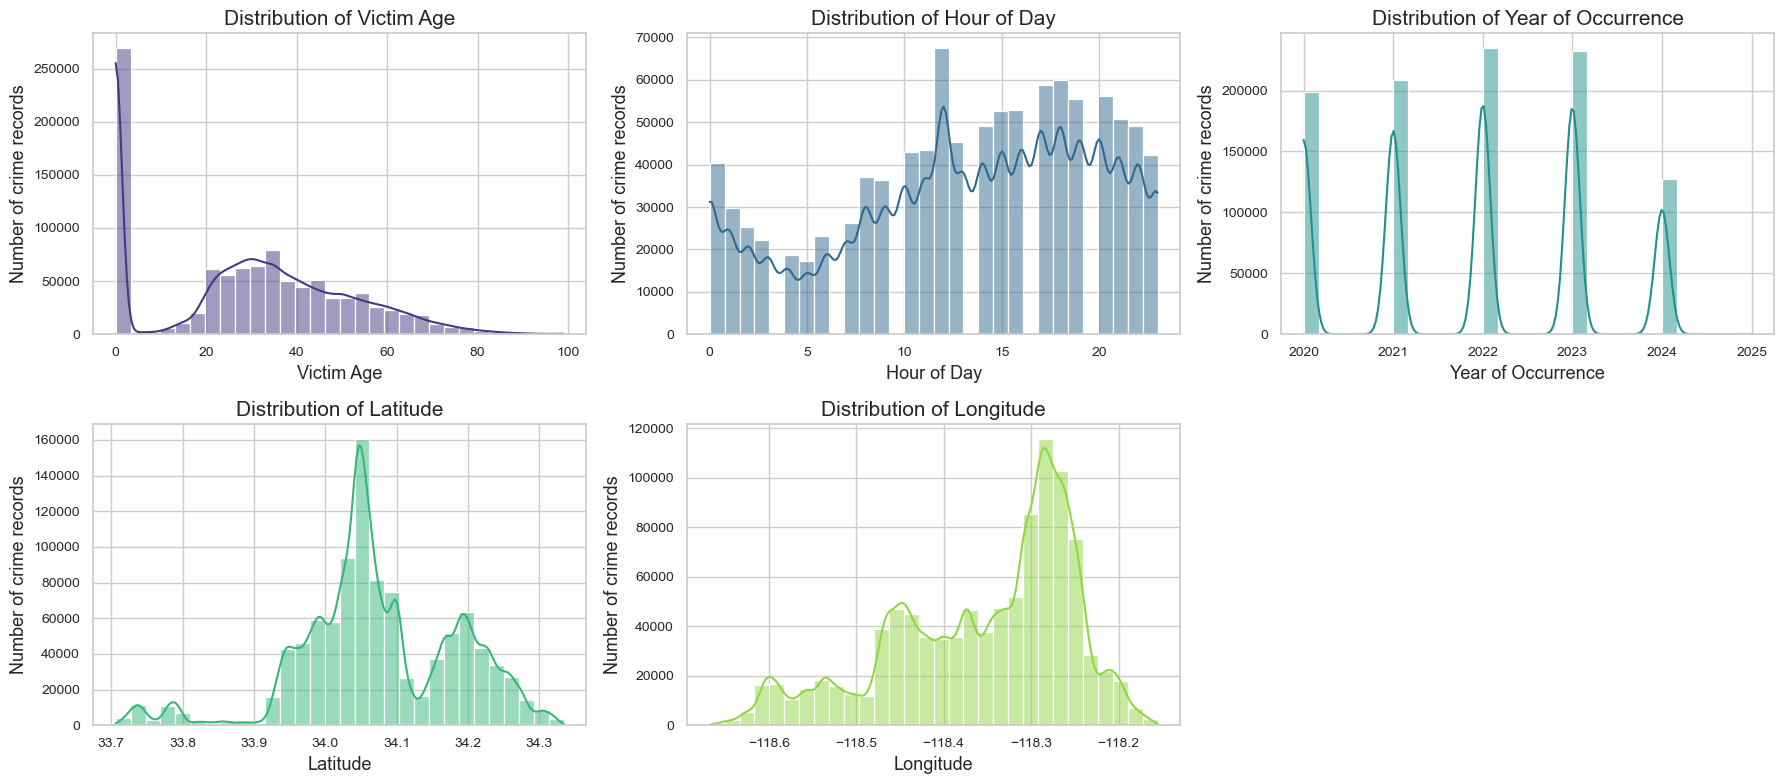

In [31]:
numeric_features = [
    "victim_age",
    "hour", 
    "year",
    "lat",
    "long",
]

feature_titles = {
    "victim_age": "Victim Age",
    "hour": "Hour of Day",
    "year": "Year of Occurrence",
    "lat": "Latitude",
    "long": "Longitude",
}

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()
colors = sns.color_palette("viridis", len(numeric_features))
title_fs = 15  
label_fs = 13
axes_used = 0
for idx, feature in enumerate(numeric_features):
    sns.histplot(
        data=df,
        x=feature,
        bins=30,
        kde=True,
        ax=axes[idx],
        color=colors[idx],
    )
    axes[idx].set_title(f"Distribution of {feature_titles.get(feature, feature)}", fontsize=title_fs)
    axes[idx].set_xlabel(feature_titles.get(feature, feature), fontsize=label_fs)
    axes[idx].set_ylabel("Number of crime records", fontsize=label_fs)
    axes[idx].tick_params(axis='both', labelsize=10)
    axes_used += 1
for ax in axes[len(numeric_features):]:
    ax.remove()
plt.tight_layout()
plt.show()


### Temporal Patterns
- Examine hour-of-day and weekday seasonality to understand deployment needs.
- Compare average incident volumes to highlight weekend vs weekday differences.

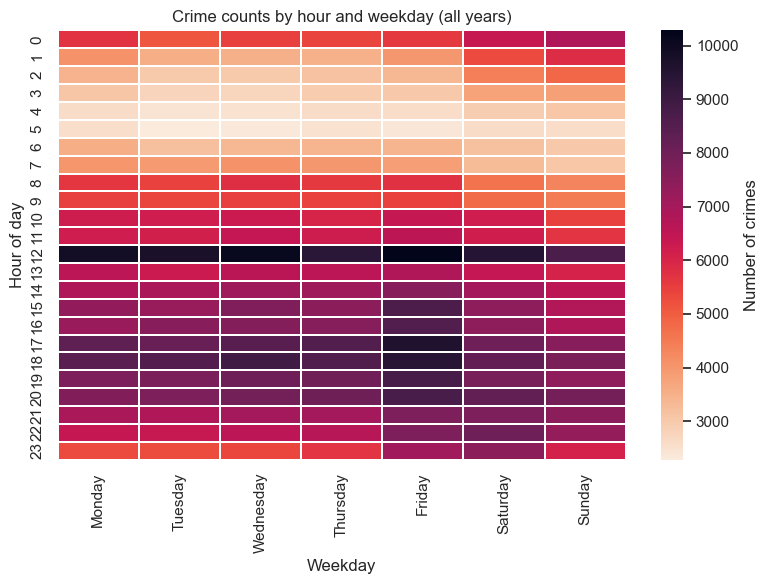

In [32]:
pivot = (
    df.assign(weekday=df["timestamp_occurred"].dt.day_name())       
      .pivot_table(index="hour", columns="weekday", values="id",
                   aggfunc="size", fill_value=0)                    
      .reindex(columns=["Monday","Tuesday","Wednesday",
                        "Thursday","Friday","Saturday","Sunday"])   
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(pivot, cmap="rocket_r", linewidths=.3, linecolor="white",
            cbar_kws={"label": "Number of crimes"}, ax=ax)
ax.set_title("Crime counts by hour and weekday (all years)")
ax.set_xlabel("Weekday")
ax.set_ylabel("Hour of day")
plt.tight_layout()
plt.show()

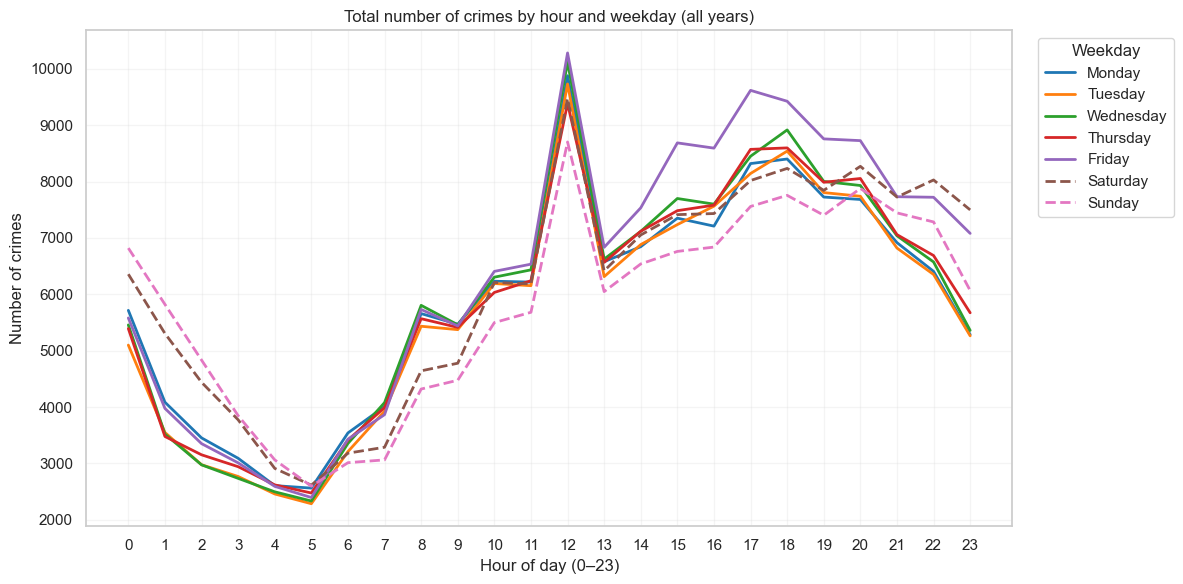

3.50% of all records have time_occurred == 12:00 (possible placeholder)


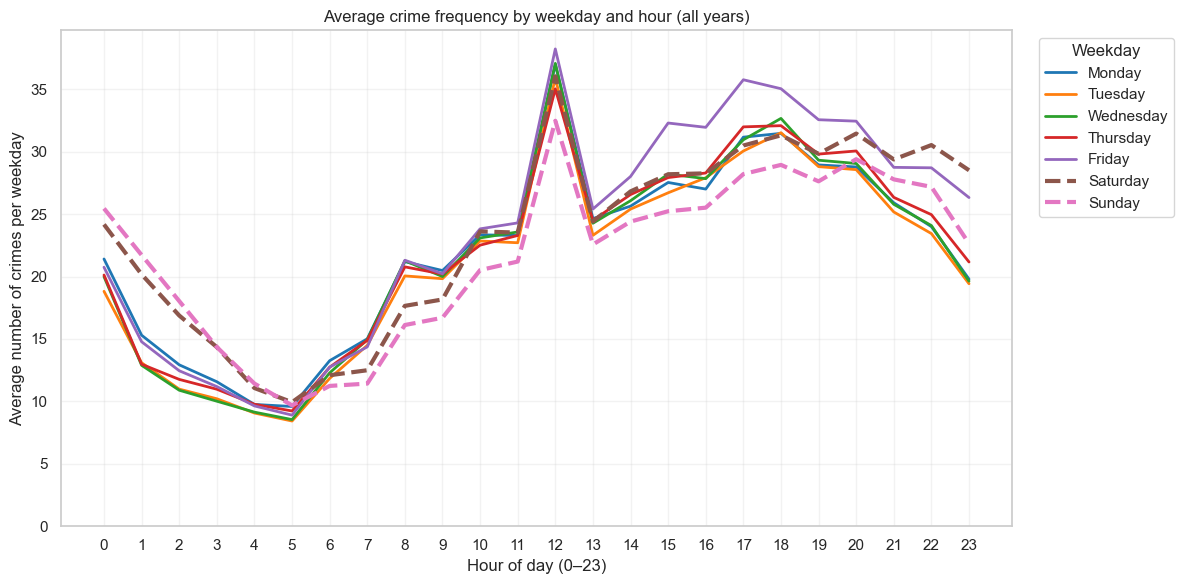

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("tab10", 7)

for i, day in enumerate(pivot.columns):
    ax.plot(
        pivot.index, pivot[day],
        label=day,
        color=palette[i],
        lw=2,
        ls="--" if day in ["Saturday", "Sunday"] else "-"
    )

ax.set_title("Total number of crimes by hour and weekday (all years)")
ax.set_xlabel("Hour of day (0–23)")
ax.set_ylabel("Number of crimes")
ax.legend(title="Weekday", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(alpha=0.2)
fig.set_size_inches(12, 6)
ax.set_xticks(range(24))
plt.tight_layout()
plt.show()

days_per_weekday = (
    df["timestamp_occurred"].dt.normalize()               # strip time → pure date
      .groupby(df["timestamp_occurred"].dt.day_name())    # group by weekday
      .nunique()                                          # # unique dates
      .reindex(pivot.columns)                             # same Mon-Sun order
      .astype(float)                                      # ensure float division
)

avg = pivot.div(days_per_weekday, axis=1)   


fig, ax = plt.subplots(figsize=(12, 6))
palette = sns.color_palette("tab10", 7)
for i, day in enumerate(avg.columns):
    ax.plot(
        avg.index, avg[day],
        label=day,
        color=palette[i],
        lw=3 if day in ["Saturday", "Sunday"] else 2,    
        ls="--" if day in ["Saturday", "Sunday"] else "-"
    )

noon_mask = df["time_occurred"] == 1200
print(f"{noon_mask.mean():.2%} of all records have time_occurred == 12:00 (possible placeholder)")
ax.set_title("Average crime frequency by weekday and hour (all years)")
ax.set_xlabel("Hour of day (0–23)")
ax.set_ylabel("Average number of crimes per weekday")
ax.set_xticks(range(0, 24, 1))
ax.set_ylim(0)                        
ax.grid(alpha=0.25)
ax.legend(title="Weekday", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Geographic Patterns

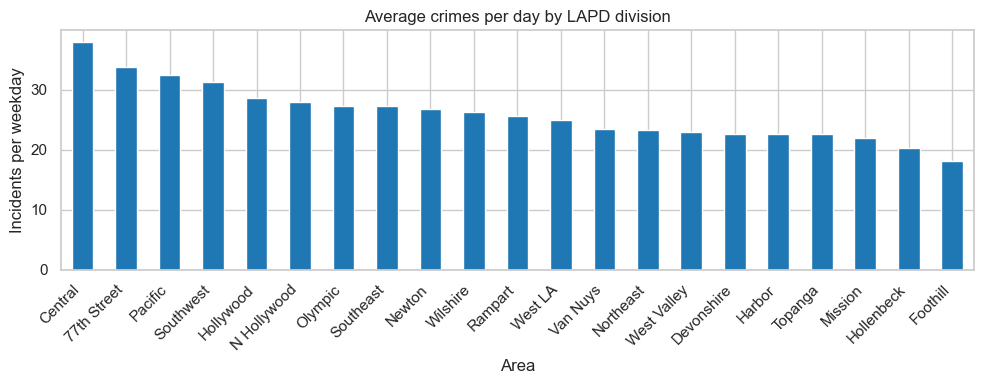

In [34]:
daily_area = (
    df.groupby(["area_name", df["timestamp_occurred"].dt.normalize()])
      .size()
      .groupby("area_name").mean()
      .sort_values(ascending=False)
)

ax = daily_area.plot(kind="bar", figsize=(10,4))
ax.set_title("Average crimes per day by LAPD division")
ax.set_ylabel("Incidents per weekday")
ax.set_xlabel("Area")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

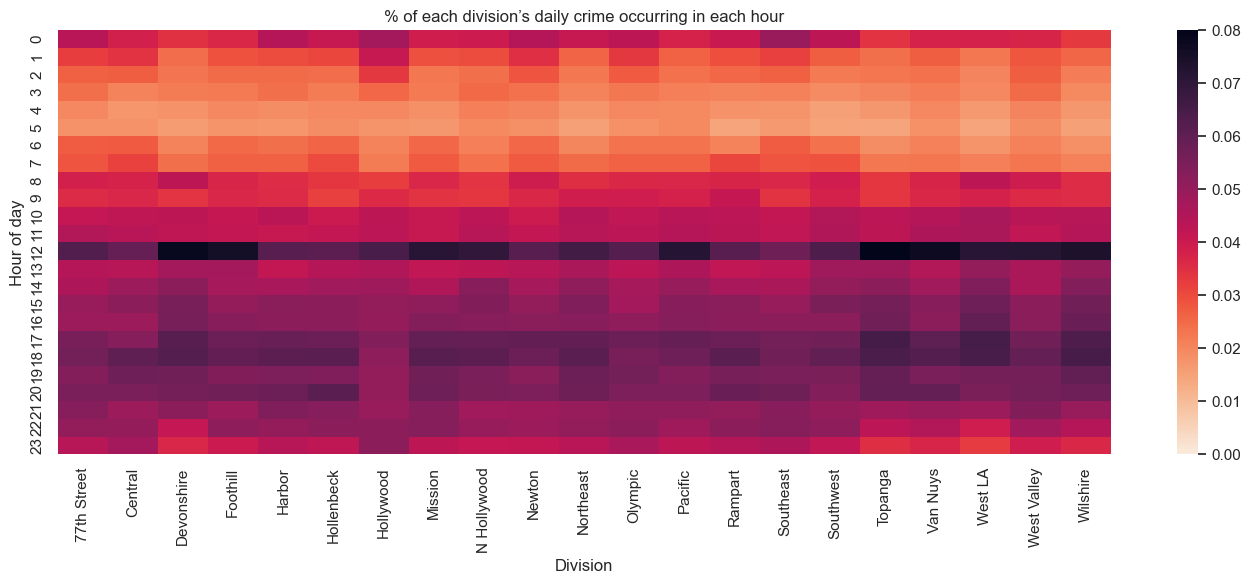

In [35]:
pivot_area_hour = (
    df.pivot_table(index="hour", columns="area_name", values="id", aggfunc="size")
      .div(days_per_weekday["Monday"], axis=0)   # optional: convert to avg/day
)
plt.figure(figsize=(14,6))
norm = pivot_area_hour.div(pivot_area_hour.sum())     # % of that division’s daily total
sns.heatmap(norm, cmap="rocket_r", vmin=0, vmax=0.08) # tighter scale
plt.title("% of each division’s daily crime occurring in each hour")
plt.ylabel("Hour of day"); plt.xlabel("Division")
plt.tight_layout(); plt.show()

### Victim & Weapon Insights
- Assess age distributions, outlier demographics, and identity theft nuances.
- Quantify weapon involvement rates and cross-tab with geography and crime types.
- Capture notable vulnerable groups to feed feature engineering ideas.

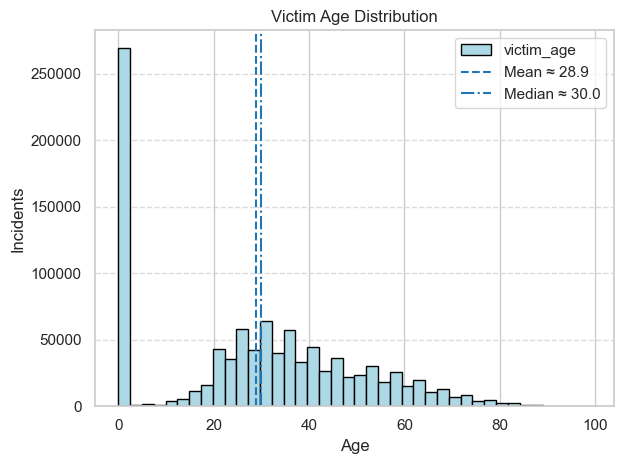

Interpretation: age distribution n=1,002,613, mean≈28.9, median=30.0, IQR≈[0.0, 44.0]. Skew=0.16.


In [36]:
ages = df["victim_age"].dropna()
plt.figure()
ages.plot(kind="hist", bins=40, edgecolor='black', color='lightblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(ages.mean(), linestyle="--", label=f"Mean ≈ {ages.mean():.1f}")
plt.axvline(ages.median(), linestyle="-.", label=f"Median ≈ {ages.median():.1f}")
plt.title("Victim Age Distribution")
plt.xlabel("Age")
plt.ylabel("Incidents")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Interpretation: age distribution n={int(df['victim_age'].notna().sum()):,}, mean≈{df['victim_age'].mean():.1f}, median={df['victim_age'].median():.1f}, "
      f"IQR≈[{df['victim_age'].quantile(0.25):.1f}, {df['victim_age'].quantile(0.75):.1f}]. Skew={df['victim_age'].skew():.2f}.")

In [37]:
print(f"Victim age 0 number of crimes: {df[df['victim_age'] == 0].shape[0]}")
print()
print("Top 5 crimes against victims age 0:")
top_10_crimes = df[df['victim_age'] == 0]['crime_desc'].value_counts().head(5)
for crime, count in top_10_crimes.items():
    percentage = (count / df[df['victim_age'] == 0].shape[0] * 100)
    print(f"{crime}: {count} ({percentage:.2f}%)")
print()
print(f"Victim age 0 identity thefts: {df[(df['victim_age'] == 0) & (df['crime_desc'] == 'THEFT OF IDENTITY')].shape[0]}")
print(f"percentage: {(df[(df['victim_age'] == 0) & (df['crime_desc'] == 'THEFT OF IDENTITY')].shape[0] / df[df['victim_age'] == 0].shape[0] * 100):.2f}%")

Victim age 0 number of crimes: 268674

Top 5 crimes against victims age 0:
VEHICLE - STOLEN: 114787 (42.72%)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER): 25008 (9.31%)
SHOPLIFTING - PETTY THEFT ($950 & UNDER): 21456 (7.99%)
BURGLARY: 18093 (6.73%)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS): 14706 (5.47%)

Victim age 0 identity thefts: 1175
percentage: 0.44%


There were only 1,175 (0.44%) cases of “Theft of Identity” for newborns. 

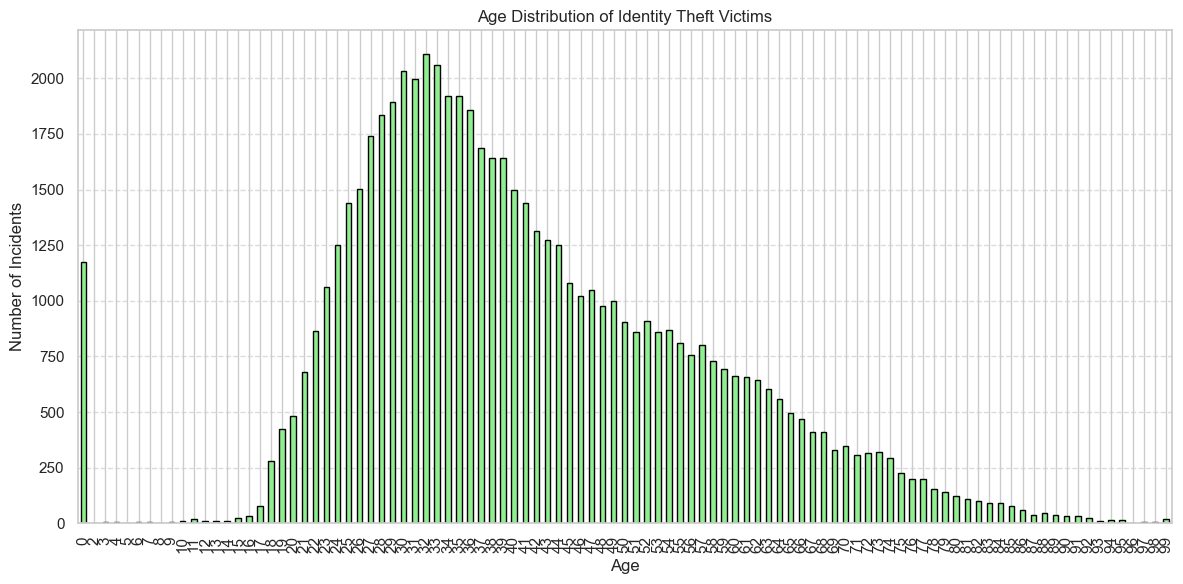

In [38]:
identity_theft = df[df['crime_desc'] == 'THEFT OF IDENTITY']
age_distribution = identity_theft['victim_age'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
age_distribution.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Age Distribution of Identity Theft Victims')
plt.xlabel('Age')
plt.ylabel('Number of Incidents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
weapon_rate = df["weapon_involved"].mean()
print(f"Only {weapon_rate:.1%} of incidents involve a weapon → strong class imbalance.")

Only 32.6% of incidents involve a weapon → strong class imbalance.


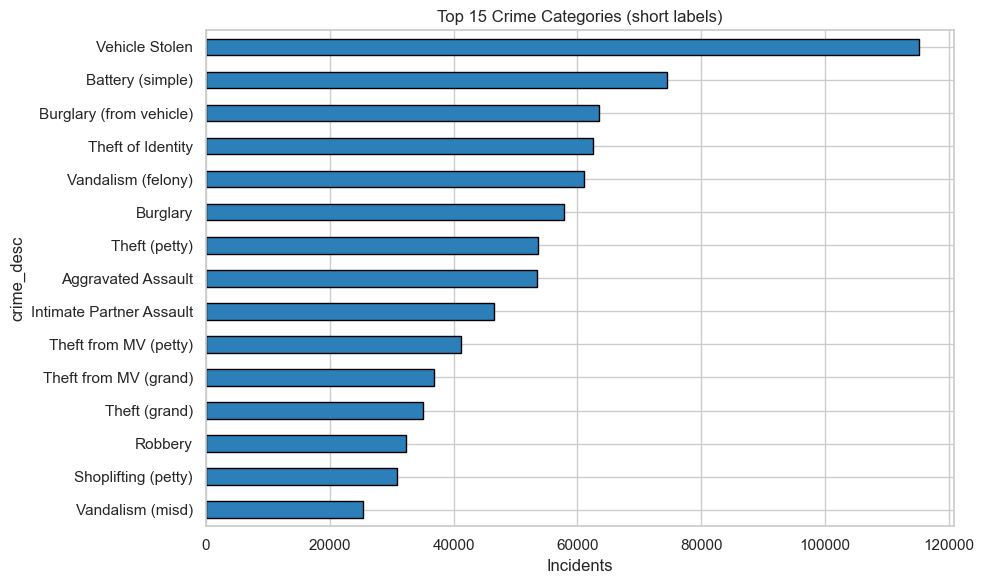

In [40]:
short_label_map = {
    "VEHICLE - STOLEN": "Vehicle Stolen",
    "BATTERY - SIMPLE ASSAULT": "Battery (simple)",
    "BURGLARY FROM VEHICLE": "Burglary (from vehicle)",
    "THEFT OF IDENTITY": "Theft of Identity",
    "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)": "Vandalism (felony)",
    "BURGLARY": "Burglary",
    "THEFT PLAIN - PETTY ($950 & UNDER)": "Theft (petty)",
    "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT": "Aggravated Assault",
    "INTIMATE PARTNER - SIMPLE ASSAULT": "Intimate Partner Assault",
    "THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)": "Theft from MV (petty)",
    "THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)": "Theft from MV (grand)",
    "THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD": "Theft (grand)",
    "ROBBERY": "Robbery",
    "SHOPLIFTING - PETTY THEFT ($950 & UNDER)": "Shoplifting (petty)",
    "VANDALISM - MISDEAMEANOR ($399 OR UNDER)": "Vandalism (misd)",
}

def short_label(crime, fallback_len=28):
    if pd.isna(crime):
        return "NA"
    s = str(crime).strip()
    if s in short_label_map:
        return short_label_map[s]
    # fallback: keep main token before " - " or truncate
    s2 = s.split(" - ")[0]
    return s2 if len(s2) <= fallback_len else s2[:fallback_len].rstrip() + "..."

# vectorized short column for use in plots
df["crime_desc_short"] = df["crime_desc"].apply(short_label)

# prepare the short labels for the Top N plotting convenience (used by later cells)
top_counts = df["crime_desc"].value_counts().head(15).sort_values()
short_labels = [short_label(idx) for idx in top_counts.index]

fig, ax = plt.subplots(figsize=(10, 6))
top_counts.plot(kind="barh", color="#2c7fb8", edgecolor="black", ax=ax)
ax.set_yticklabels(short_labels)
ax.set_title("Top 15 Crime Categories (short labels)")
ax.set_xlabel("Incidents")
plt.tight_layout()
plt.show()


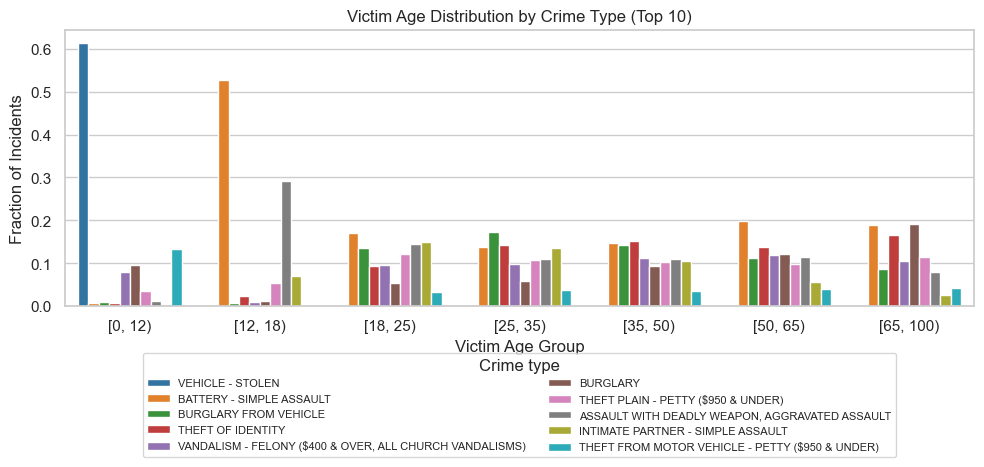

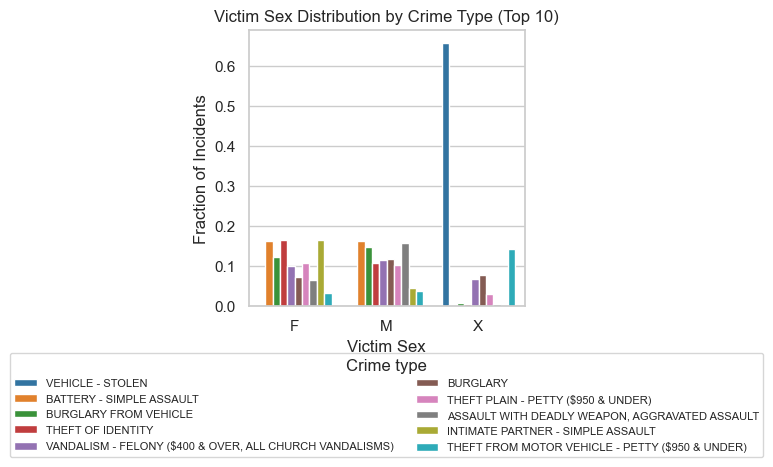

In [41]:
# TopN = 10
top_crimes = df['crime_desc'].value_counts().head(10).index.tolist()

# work on filtered copies so original df stays intact
df_age = df[df['victim_age'].notna() & df['crime_desc'].notna()].copy()
bins = [0, 12, 18, 25, 35, 50, 65, 100]
age_labels = ["[0, 12)", "[12, 18)", "[18, 25)", "[25, 35)", "[35, 50)", "[50, 65)", "[65, 100)"]
df_age["age_bin"] = pd.cut(df_age["victim_age"], bins=bins, labels=age_labels, right=False)

# crosstab and keep only the top crimes (fill missing columns with 0)
ct = pd.crosstab(df_age["age_bin"], df_age["crime_desc"]).reindex(columns=top_crimes, fill_value=0)

# normalize per age_bin, guard against rows that sum to zero
sums = ct.sum(axis=1)
ct_norm = ct.div(sums.replace(0, np.nan), axis=0).fillna(0)

age_ct = ct_norm.stack().reset_index(name="fraction")
age_ct["age_bin"] = age_ct["age_bin"].astype(pd.CategoricalDtype(categories=age_labels, ordered=True))

plt.figure(figsize=(10, 5))
sns.barplot(
    data=age_ct,
    x="age_bin",
    y="fraction",
    hue="crime_desc",
    hue_order=top_crimes,
    palette="tab10",
)
plt.title("Victim Age Distribution by Crime Type (Top 10)")
plt.xlabel("Victim Age Group")
plt.ylabel("Fraction of Incidents")
plt.legend(title="Crime type", bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Victim sex distribution (same protections)
df_sex = df[df['victim_sex'].notna() & df['crime_desc'].notna()].copy()
ct2 = pd.crosstab(df_sex["victim_sex"], df_sex["crime_desc"]).reindex(columns=top_crimes, fill_value=0)
sums2 = ct2.sum(axis=1)
ct2_norm = ct2.div(sums2.replace(0, np.nan), axis=0).fillna(0)

sex_ct = ct2_norm.stack().reset_index(name="fraction")

plt.figure(figsize=(6, 5))
sns.barplot(
    data=sex_ct,
    x="victim_sex",
    y="fraction",
    hue="crime_desc",
    hue_order=top_crimes,
    palette="tab10",
)
plt.title("Victim Sex Distribution by Crime Type (Top 10)")
plt.xlabel("Victim Sex")
plt.ylabel("Fraction of Incidents")
plt.legend(title="Crime type", bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

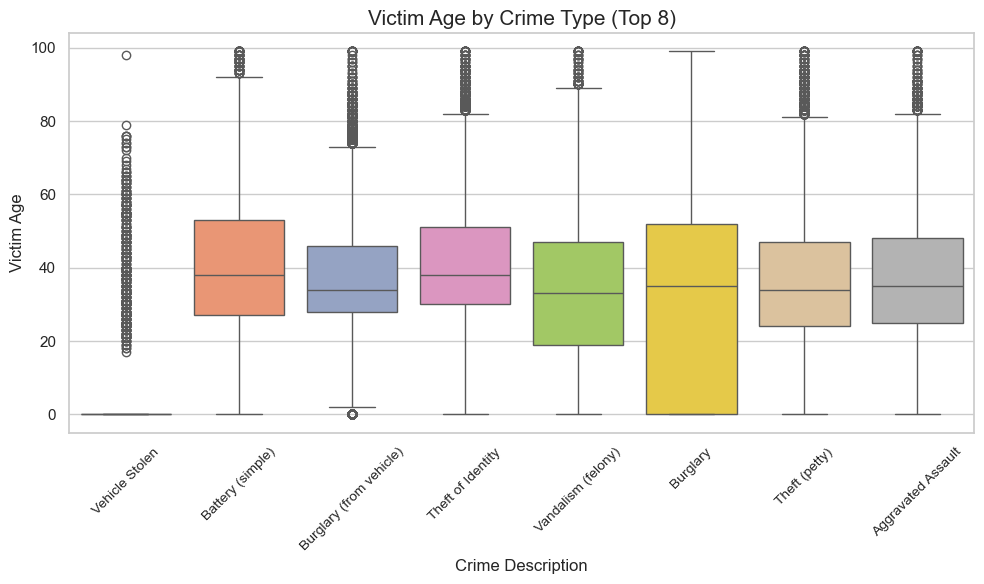

In [42]:
top8 = df['crime_desc'].value_counts().head(8).index.tolist()
subset = df[df['crime_desc'].isin(top8) & df['victim_age'].notna()].copy()

if 'crime_desc_short' not in subset.columns:
    subset['crime_desc_short'] = subset['crime_desc'].apply(short_label)

order = [short_label(c) for c in top8]
plt.figure(figsize=(10, 6))
sns.boxplot(data=subset, x='crime_desc_short', y='victim_age', palette='Set2', order=order)
plt.title('Victim Age by Crime Type (Top 8)', fontsize=15)
plt.xlabel('Crime Description', fontsize=12)
plt.ylabel('Victim Age', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

### Feature Relationships & Correlations
- Quantify relationships among numeric features (e.g., victim age, timestamps, weapon flags).
- Use both Plotly and Matplotlib heatmaps to highlight strong linear correlations.
- Note any multicollinearity concerns to inform model regularization.

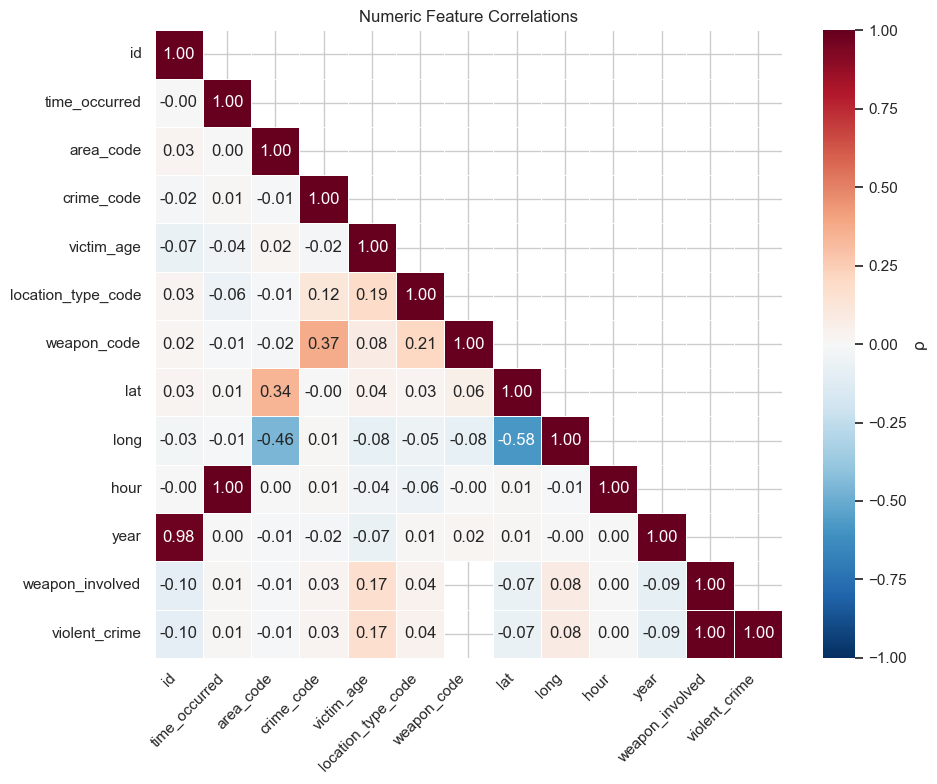

In [43]:
num_cols = df.select_dtypes(include="number").columns

if len(num_cols) >= 2:
    corr = df[num_cols].corr().round(2)

    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        corr,
        mask=mask,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
        annot=True, fmt=".2f",
        linewidths=0.4,
        cbar_kws={"label": "ρ"},
        square=True,
        ax=ax,
    )
    ax.set_title("Numeric Feature Correlations")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlation matrix.")


### Crime Mix by Area & Crime Category Highlights

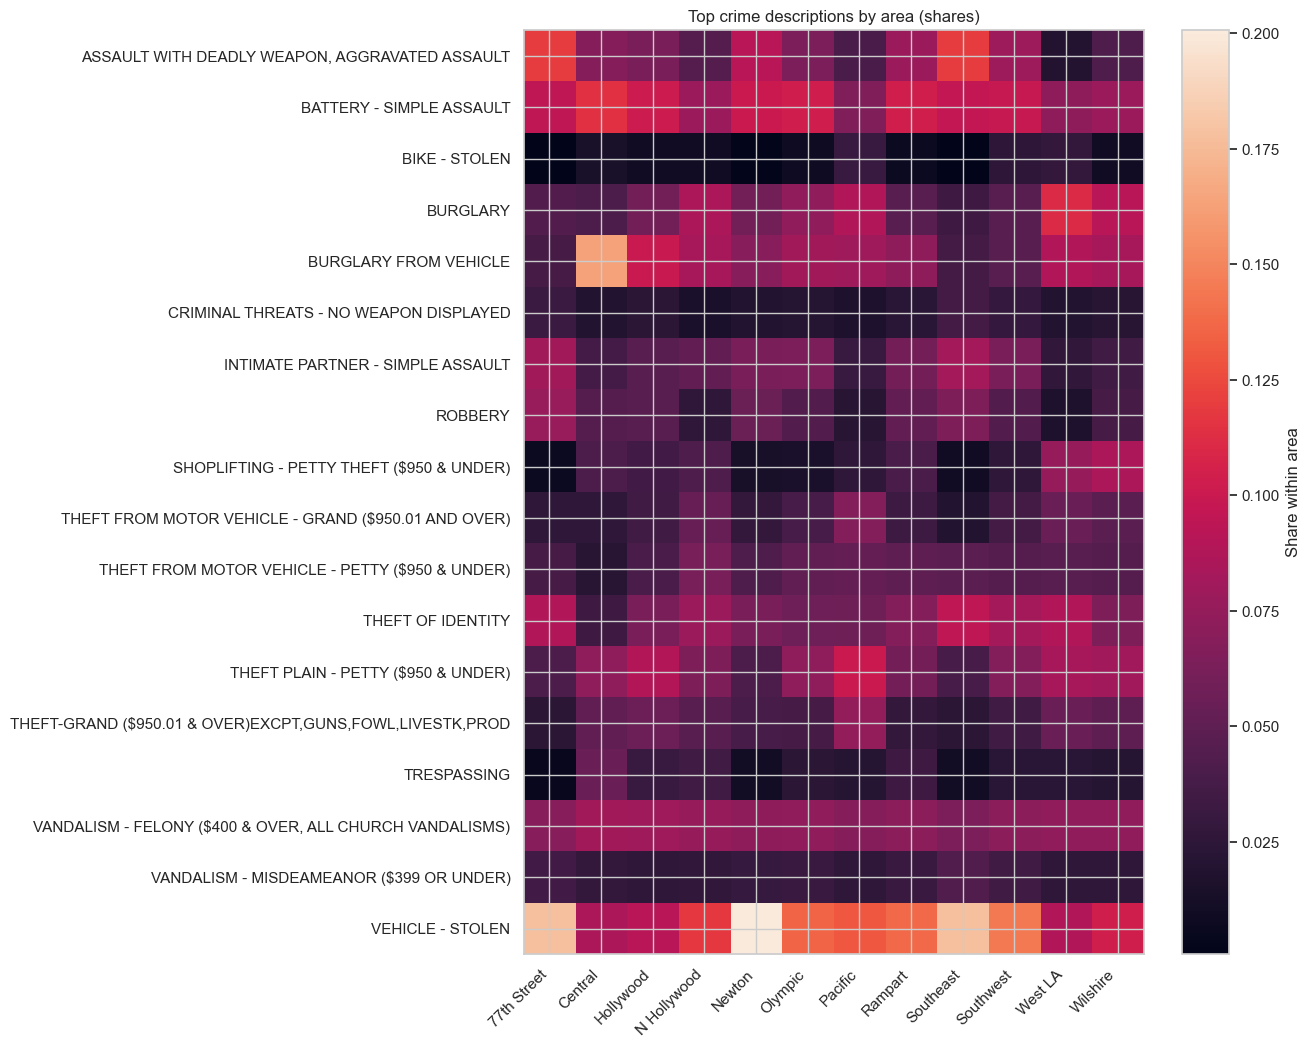

In [44]:
# pick busiest areas and most-informative crimes
top_areas = df["area_name"].value_counts().head(12).index
d = df[df["area_name"].isin(top_areas)].copy()
# union of top-k crimes within each area keeps rows compact but relevant
k = 12
keep_crimes = set().union(*[set(d.loc[d["area_name"]==a, "crime_desc"].value_counts().head(k).index) for a in top_areas])
d = d[d["crime_desc"].isin(keep_crimes)]

# crosstab -> normalize per area (column) so colors mean "share within area"
ct = pd.crosstab(d["crime_desc"], d["area_name"])
hm = ct.div(ct.sum(0), axis=1).fillna(0)

plt.figure(figsize=(10, 0.5*len(hm) + 3))
plt.imshow(hm.values, aspect="auto")
plt.xticks(range(hm.shape[1]), hm.columns, rotation=45, ha="right")
plt.yticks(range(hm.shape[0]), hm.index)
plt.colorbar(label="Share within area")
plt.title("Top crime descriptions by area (shares)")
plt.show()

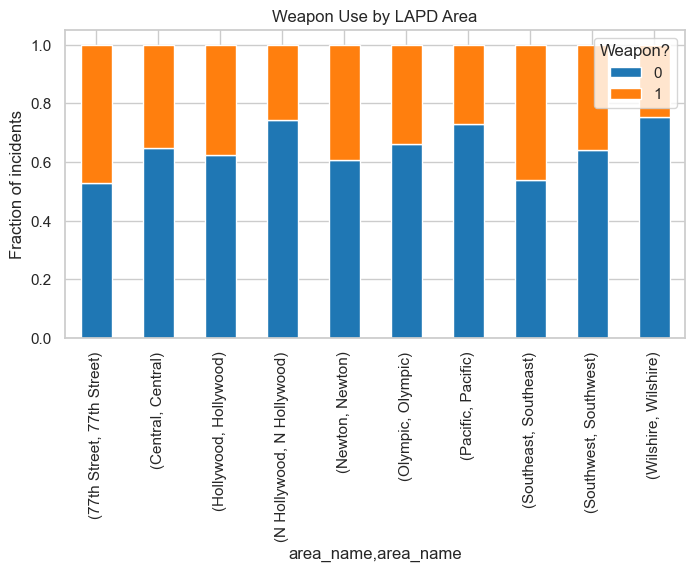

In [45]:
top_areas = df["area_name"].value_counts().head(10).index
tmp = (df[df["area_name"].isin(top_areas)]
       .groupby(["area_name","weapon_involved"]).size()
       .groupby(level=0).apply(lambda s: s/s.sum())
       .unstack().fillna(0))
tmp.plot(kind="bar", stacked=True, figsize=(8,4))
plt.legend(title="Weapon?"); plt.ylabel("Fraction of incidents"); plt.title("Weapon Use by LAPD Area")
plt.show()

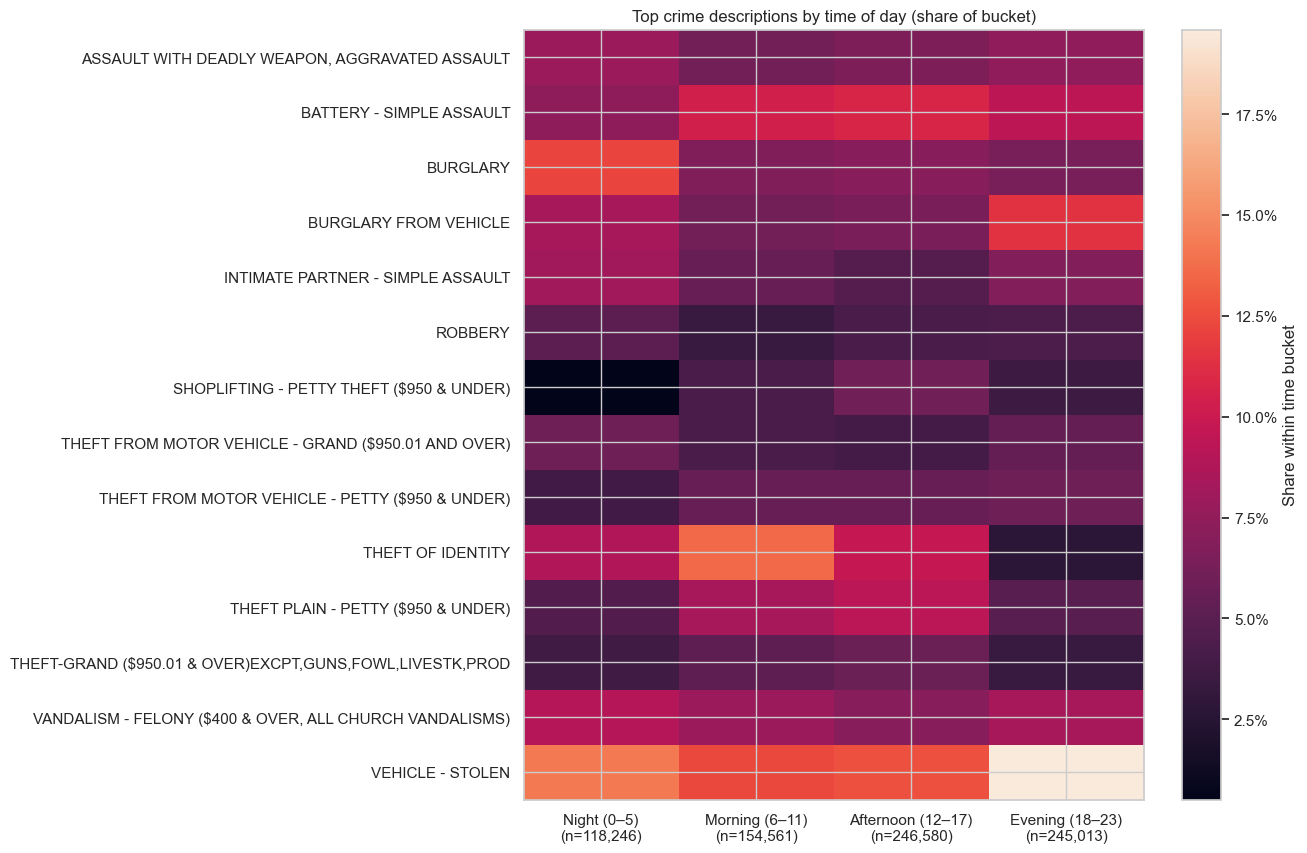

In [46]:
K = 12  
labels = ["Night (0–5)", "Morning (6–11)", "Afternoon (12–17)", "Evening (18–23)"]

h = pd.to_numeric(df["hour"], errors="coerce")
h = h.clip(lower=0, upper=24-1e-9)  # keep [0,24)
tod = pd.cut(h, bins=[0,6,12,18,24], right=False, labels=labels)
d = df.assign(
    time_of_day=tod.astype("object").fillna("NA"),
    crime_desc=df["crime_desc"].astype("string").fillna("NA"),
)
present = [b for b in labels if (d["time_of_day"] == b).any()]
if not present:
    present = ["NA"]

keep = set()
for b in present:
    sub = d[d["time_of_day"] == b]
    keep |= set(sub["crime_desc"].value_counts().head(K).index)
if not keep:
    keep = set(d["crime_desc"].value_counts().head(K).index)

d = d[d["crime_desc"].isin(keep) & d["time_of_day"].isin(present)]
ct = pd.crosstab(d["crime_desc"], d["time_of_day"])
ct = ct.reindex(columns=present, fill_value=0)
shares = ct.div(ct.sum(0), axis=1).fillna(0)
plt.figure(figsize=(10, 0.5*len(shares) + 3))
im = plt.imshow(shares.values, aspect="auto")
plt.xticks(
    range(len(present)),
    [f"{c}\n(n={int(ct[c].sum()):,})" for c in present],
    rotation=0
)
plt.yticks(range(shares.shape[0]), shares.index)
cbar = plt.colorbar(im, format=PercentFormatter(xmax=1))
cbar.set_label("Share within time bucket")
plt.title("Top crime descriptions by time of day (share of bucket)")
plt.show()


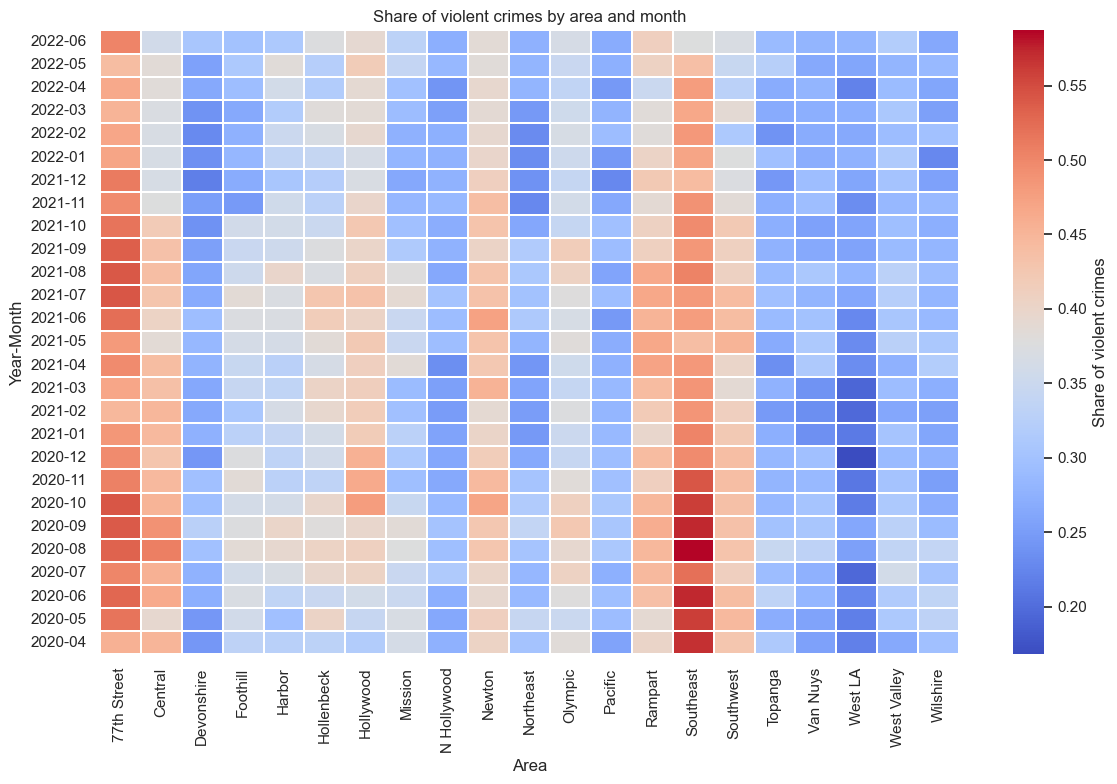

In [47]:
df["year_month"] = df["timestamp_occurred"].dt.to_period("M")
mask = df["year_month"].between("2020-04", "2022-06")

time_area_month = (
    df.loc[mask]
      .groupby(["year_month", "area_name"])["violent_crime"]
      .mean()
      .unstack()
      .fillna(0)
      .sort_index(ascending=False)
)

plt.figure(figsize=(12,8))
sns.heatmap(time_area_month, cmap="coolwarm", linewidths=.3, linecolor="white",
            cbar_kws={"label": "Share of violent crimes"})
plt.title("Share of violent crimes by area and month")
plt.xlabel("Area")
plt.ylabel("Year-Month")
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

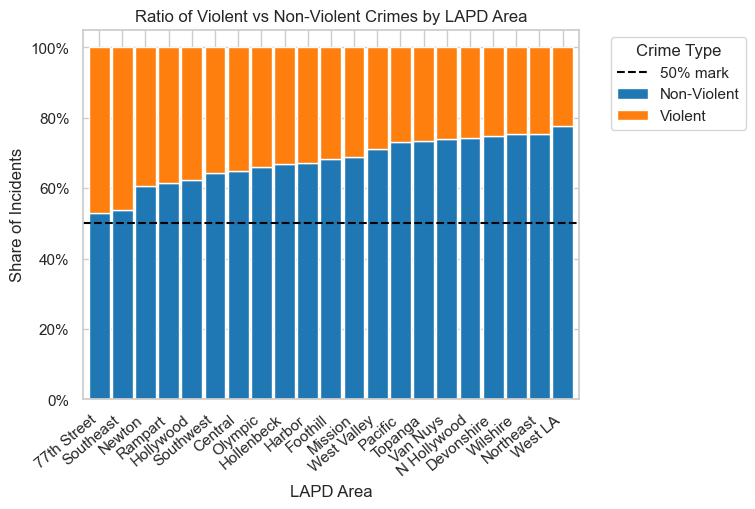

In [ ]:
ct = pd.crosstab(df["area_name"], df["crime_type"])

# Normalize per area to get share (ratio)
ct_ratio = ct.div(ct.sum(axis=1), axis=0)

# Sort areas by the fraction of violent crimes (descending)
ct_ratio = ct_ratio.sort_values(by="Violent", ascending=False)

# Plot a stacked bar chart
# make the graph larger horizontally 
plt.figure(figsize=(12,10))
ax = ct_ratio.plot(kind="bar", stacked=True, width=0.9)

plt.title("Ratio of Violent vs Non-Violent Crimes by LAPD Area")
plt.xlabel("LAPD Area")
plt.ylabel("Share of Incidents")

# Draw the 50% reference line
plt.axhline(0.5, color="black", linestyle="--", label="50% mark")

# Format y-axis ticks as percentage
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Rotate x-tick labels for better legibility
plt.xticks(rotation=40, ha="right")

# Place the legend outside the plot area
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [49]:
def agg_area_time(df, freq='M'):  # freq='M' (month) or 'Y' (year)
    g = (df.assign(period=df['timestamp_occurred'].dt.to_period(freq).dt.to_timestamp())
           .groupby(['period','area_name','crime_type'])
           .size().rename('count').reset_index())
    tot = g.groupby(['period','area_name'])['count'].transform('sum')
    g['pct_of_area_period'] = 100 * g['count'] / tot
    return g

monthly = agg_area_time(df, 'M')
yearly  = agg_area_time(df, 'Y')

In [50]:
df['date'] = pd.to_datetime(df['timestamp_occurred'])
yearly = (df.assign(year=df['date'].dt.year)
            .groupby(['year','area_name','crime_type'])
            .size().rename('count').reset_index())

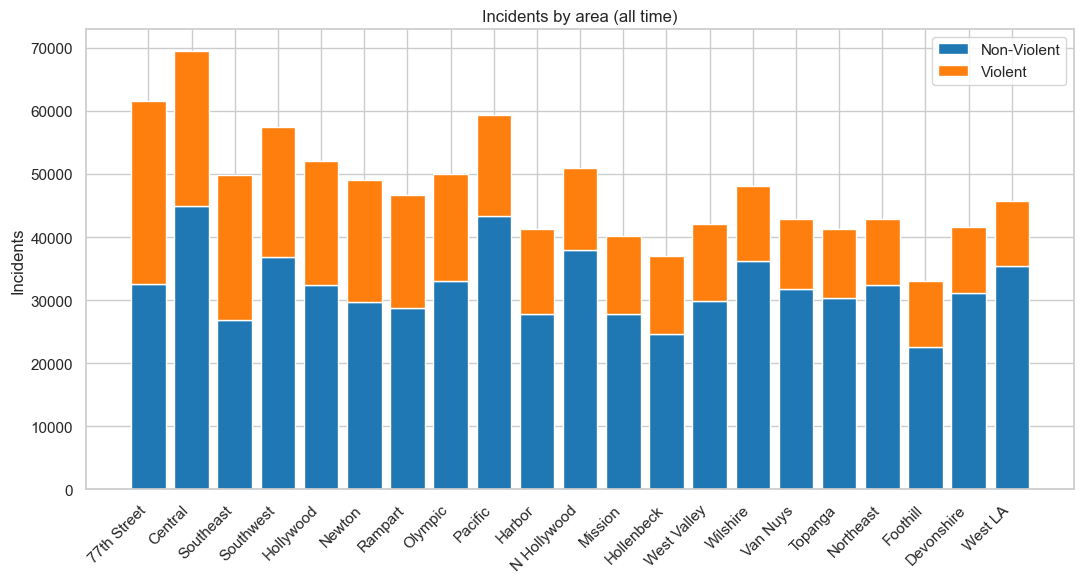

In [51]:
alltime = (df.groupby(['area_name','crime_type'])
             .size().rename('count').reset_index())
stack = (alltime.pivot(index='area_name', columns='crime_type', values='count')
                 .fillna(0)
                 .sort_values(['Violent','Non-Violent'], ascending=False))

plt.figure(figsize=(11,6))
bottom = np.zeros(len(stack))
for col in stack.columns:              # 'Non-Violent', 'Violent'
    vals = stack[col].values
    plt.bar(stack.index, vals, bottom=bottom, label=col)
    bottom += vals
plt.xticks(rotation=45, ha='right'); plt.ylabel('Incidents')
plt.title('Incidents by area (all time)')
plt.legend(); plt.tight_layout(); plt.show()


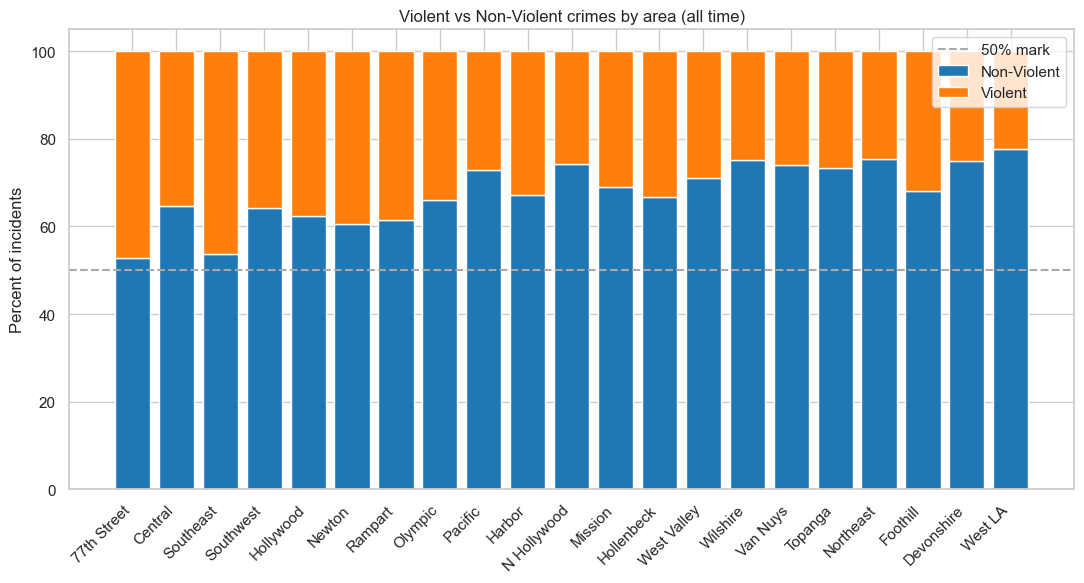

In [52]:
share = stack.div(stack.sum(axis=1), axis=0).fillna(0) * 100
plt.figure(figsize=(11,6))
bottom = np.zeros(len(share))
for col in share.columns:
    vals = share[col].values
    plt.bar(share.index, vals, bottom=bottom, label=col)
    bottom += vals
plt.xticks(rotation=45, ha='right'); plt.ylabel('Percent of incidents')
# 50 % hosrizontal line
plt.axhline(50, color="darkgrey", linestyle="--", label="50% mark")
plt.title('Violent vs Non-Violent crimes by area (all time)')
plt.legend(); plt.tight_layout(); plt.show()

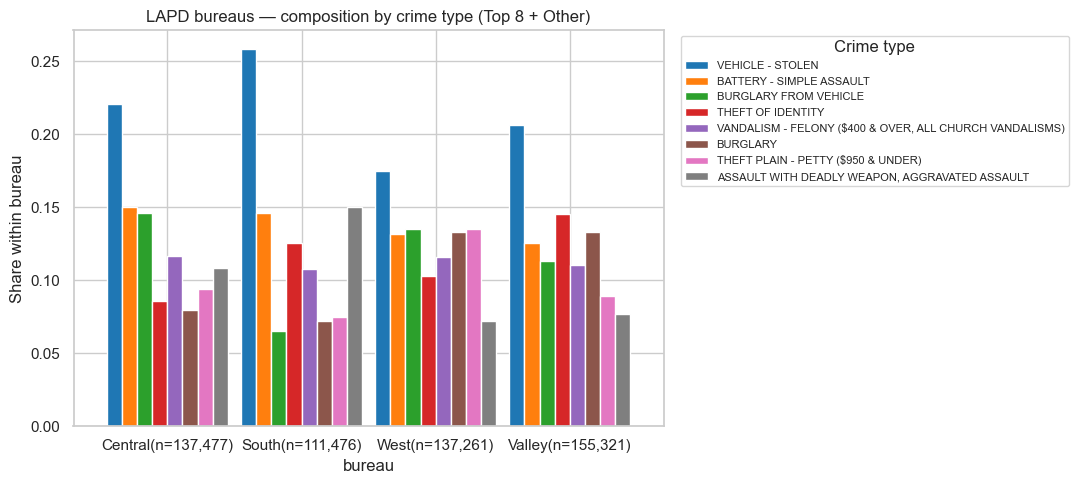

In [53]:
# Map LAPD divisions ("area_name") to four LAPD bureaus
bureau_map = {
    "CENTRAL":"Central","HOLLENBECK":"Central","NEWTON":"Central","NORTHEAST":"Central","RAMPART":"Central",
    "77TH STREET":"South","SEVENTY-SEVENTH STREET":"South","77TH ST":"South","7TH STREET":"South",
    "HARBOR":"South","SOUTHEAST":"South","SOUTHWEST":"South",
    "HOLLYWOOD":"West","OLYMPIC":"West","PACIFIC":"West","WEST LA":"West","WEST L.A.":"West","WILSHIRE":"West",
    "DEVONSHIRE":"Valley","FOOTHILL":"Valley","MISSION":"Valley","NORTH HOLLYWOOD":"Valley","N HOLLYWOOD":"Valley",
    "N. HOLLYWOOD":"Valley","TOPANGA":"Valley","VAN NUYS":"Valley","WEST VALLEY":"Valley",
}

def to_bureau(area_name):
    if pd.isna(area_name):
        return np.nan
    s = str(area_name).strip().upper()
    s = s.replace("WEST L.A.", "WEST LA")
    if s == "7TH STREET":
        s = "77TH STREET"
    return bureau_map.get(s, np.nan)

d = df[['area_name','crime_desc']].copy()
d['bureau'] = d['area_name'].apply(to_bureau)
d = d.dropna(subset=['bureau'])
d['crime_desc'] = d['crime_desc'].astype('string')

k = 8
top_crimes = d['crime_desc'].value_counts().head(k).index
d['crime_fixed'] = d['crime_desc'].where(d['crime_desc'].isin(top_crimes))

ct = pd.crosstab(d['bureau'], d['crime_fixed'])
cols = list(top_crimes) + [c for c in ct.columns if c not in top_crimes]
ct = ct.reindex(columns=cols, fill_value=0)

order = [b for b in ["Central","South","West","Valley"] if b in ct.index]
ct = ct.loc[order]

plot_df = ct.div(ct.sum(1), axis=0)
ns = ct.sum(1)

ax = plot_df.plot(kind='bar', stacked=False, figsize=(11,5), width=0.9)
ax.set_ylabel("Share within bureau")
ax.set_title(f"LAPD bureaus — composition by crime type (Top {k} + Other)")
ax.set_xticklabels([f"{b}(n={int(ns[b]):,})" for b in plot_df.index], rotation=0)
ax.legend(title='Crime type', bbox_to_anchor=(1.02, 1), loc='upper left', ncols=1, fontsize=8)
plt.tight_layout()
plt.show()

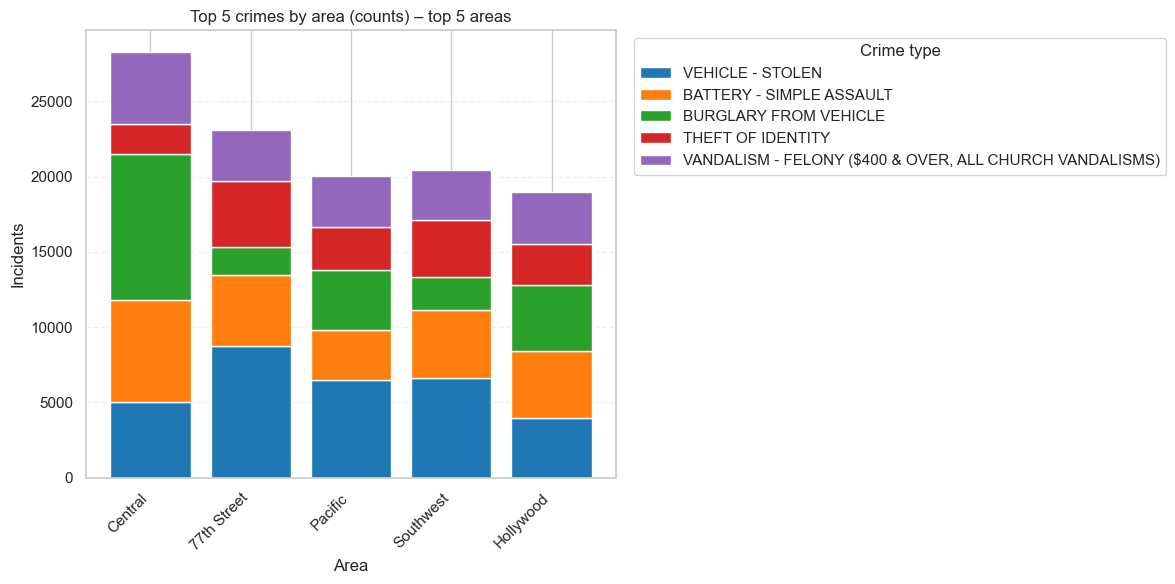

In [ ]:
top_areas = 5       
focus_k   = 5      

subset = df[['area_name', 'crime_desc']].dropna(subset=['area_name', 'crime_desc']).copy()
subset['area_name'] = subset['area_name'].astype('string')
subset['crime_desc'] = subset['crime_desc'].astype('string')

areas = subset['area_name'].value_counts().head(top_areas).index.tolist()
top_crimes = subset['crime_desc'].value_counts().head(focus_k).index.tolist()

counts = (subset[subset['area_name'].isin(areas) & subset['crime_desc'].isin(top_crimes)]
          .groupby(['area_name', 'crime_desc']).size()
          .unstack(fill_value=0)
          .reindex(index=areas, columns=top_crimes, fill_value=0))

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(counts))
for crime in top_crimes:
    ax.bar(counts.index, counts[crime], bottom=bottom, label=crime)
    bottom += counts[crime].values

ax.set_title(f"Top {focus_k} crimes by area (counts) – top {len(areas)} areas")
ax.set_xlabel("Area")
ax.set_ylabel("Incidents")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(title="Crime type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


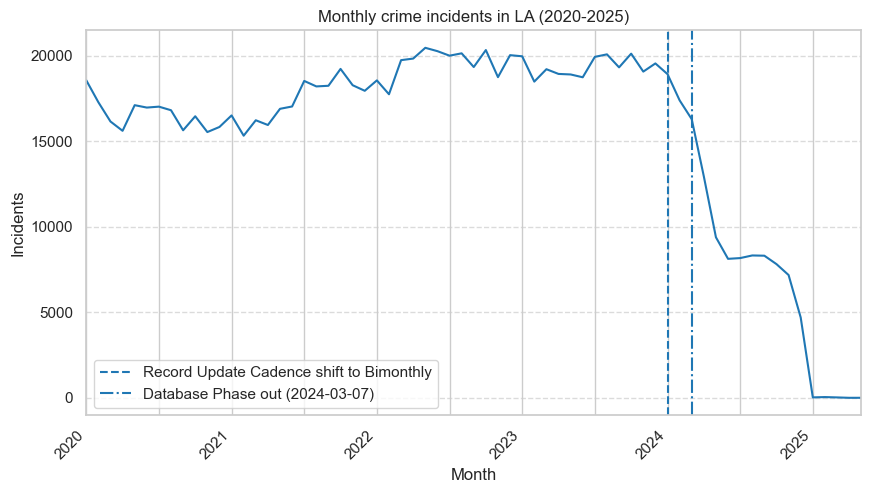

In [55]:
monthly = df.groupby(df['timestamp_occurred'].dt.to_period("M")).size()
monthly.plot(figsize=(10,5))
plt.title("Monthly crime incidents in LA (2020-2025)")
add_event_marker(plt.gca(), biweekly_note, linestyle="--", label="Record Update Cadence shift to Bimonthly")
add_event_marker(plt.gca(), rms_date, linestyle="-.", label="Database Phase out (2024-03-07)")
plt.legend()
plt.xlabel("Month")
plt.xticks(rotation=45, ha="right")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.ylabel("Incidents")
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [56]:
helper_cols = ['date', 'year_month']
existing = [col for col in helper_cols if col in df.columns]
if existing:
    df = df.drop(columns=existing)
    print(f'Dropped helper columns: {existing}')


Dropped helper columns: ['date', 'year_month']


# Appendix

In [57]:
df.describe(include='object').T

,count,unique,top,freq
area_name,1002613,21,Central,69462
crime_desc,1002613,140,VEHICLE - STOLEN,115132
victim_sex,1002613,3,M,402914
victim_descent,1002613,19,Hispanic,295587
location_type_desc,1002025,306,STREET,260889
weapon_desc,1002613,80,NO WEAPON,676211
crime_street,1002613,66535,800 N ALAMEDA ST,2582
weekday,1002613,7,Friday,153303
month,1002613,12,January,92557
crime_type,1002613,2,Non-Violent,676073


In [58]:
# Categorical frequency tables (top 10)
def vc(s):
    return (s.value_counts().head(10).to_frame("top 10")
              .assign(**{"%": lambda x: (x["top 10"] * 100 / len(s)).round().astype(int).astype(str) + "%"}))
for col in ["crime_desc", "location_type_desc", "weapon_desc", "area_name", "victim_age", "victim_descent", "victim_sex", "weekday", "month", "year"]:
    display(col, vc(df[col]))

'crime_desc'

,top 10,%
crime_desc,,
VEHICLE - STOLEN,115132,11%
BATTERY - SIMPLE ASSAULT,74483,7%
BURGLARY FROM VEHICLE,63462,6%
THEFT OF IDENTITY,62497,6%
"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",61018,6%
BURGLARY,57849,6%
THEFT PLAIN - PETTY ($950 & UNDER),53591,5%
"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",53503,5%
INTIMATE PARTNER - SIMPLE ASSAULT,46488,5%


'location_type_desc'

,top 10,%
location_type_desc,,
STREET,260889,26%
SINGLE FAMILY DWELLING,163220,16%
"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",118674,12%
PARKING LOT,69049,7%
OTHER BUSINESS,47493,5%
SIDEWALK,40741,4%
"VEHICLE, PASSENGER/TRUCK",29256,3%
GARAGE/CARPORT,19338,2%
DRIVEWAY,16060,2%


'weapon_desc'

,top 10,%
weapon_desc,,
NO WEAPON,676211,67%
"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",174124,17%
UNKNOWN WEAPON/OTHER WEAPON,36322,4%
VERBAL THREAT,23831,2%
HAND GUN,20175,2%
SEMI-AUTOMATIC PISTOL,7258,1%
KNIFE WITH BLADE 6INCHES OR LESS,6831,1%
UNKNOWN FIREARM,6576,1%
OTHER KNIFE,5870,1%


'area_name'

,top 10,%
area_name,,
Central,69462,7%
77th Street,61624,6%
Pacific,59335,6%
Southwest,57375,6%
Hollywood,52101,5%
N Hollywood,51011,5%
Olympic,49927,5%
Southeast,49790,5%
Newton,49072,5%


'victim_age'

,top 10,%
victim_age,,
0,268674,27%
30,22238,2%
35,21791,2%
31,21372,2%
29,21296,2%
28,20927,2%
32,20806,2%
33,20324,2%
27,20084,2%


'victim_descent'

,top 10,%
victim_descent,,
Hispanic,295587,29%
Unknown,250801,25%
White,200994,20%
Black,135488,14%
Other,77815,8%
Other Asian,21309,2%
Korean,5981,1%
Filipino,4832,0%
Chinese,4630,0%


'victim_sex'

,top 10,%
victim_sex,,
M,402914,40%
F,357671,36%
X,242028,24%


'weekday'

,top 10,%
weekday,,
Friday,153303,15%
Saturday,147095,15%
Wednesday,142379,14%
Thursday,141483,14%
Monday,141234,14%
Sunday,139305,14%
Tuesday,137814,14%


'month'

,top 10,%
month,,
January,92557,9%
March,87656,9%
February,86283,9%
October,83964,8%
July,83660,8%
August,83567,8%
April,83281,8%
May,82765,8%
June,81139,8%


'year'

,top 10,%
year,,
2022,235216,23%
2023,232336,23%
2021,208383,21%
2020,199014,20%
2024,127567,13%
2025,97,0%


In [59]:
def get_top_20_dict(df):
    return {col: df[col].value_counts().head(20) for col in df.columns}

In [ ]:
def plot_top_frequencies(
    df: pd.DataFrame,
    top_n: int = 20,
    max_unique_numeric: int = 30,
    treat_as_categorical=["crime_severity_code", "hour"],
    skip_cols=["area_code", "id", "lat", "long", "crime_street", "hour", "date", "year_month",
               "sub_area_code", "weapon_code", "crime_code", "location_type_code", "crime_code"],  # skip high-card ID/coords/free-text
    by_date_for_datetime=True, 
):
    treat_as_categorical = set(treat_as_categorical or [])
    skip_cols = set(skip_cols or [])

    for col in df.columns:
        if col in skip_cols:
            continue

        s = df[col]
        is_datetime = pd.api.types.is_datetime64_any_dtype(s)
        is_object_like = (pd.api.types.is_object_dtype(s) or 
                          pd.api.types.is_string_dtype(s) or
                          pd.api.types.is_categorical_dtype(s))
        is_numeric = pd.api.types.is_numeric_dtype(s)

        use_as_categorical = (
            col in treat_as_categorical
            or is_object_like
            or is_datetime
            or (is_numeric and s.nunique(dropna=True) <= max_unique_numeric)
        )

        # Prepare the series for counting
        if is_datetime:
            s_count = (s.dt.date if by_date_for_datetime else s)
        else:
            s_count = s

        # Count including NaN as its own bucket
        vc = s_count.value_counts(dropna=False)

        if not use_as_categorical:
            # For high-cardinality numeric (e.g., IDs, coordinates), skip by default
            # You can comment this out if you want *everything* plotted.
            continue

        top = vc.head(top_n)
        # Build display index with NA label
        idx_display = [("NA" if (isinstance(k, float) and np.isnan(k)) or k is pd.NA or k is None else k) 
                       for k in top.index]
        # Convert to strings to avoid matplotlib axis issues
        idx_display = [str(x) for x in idx_display]

        # Plot
        plt.figure(figsize=(10, max(3, min(top_n, 20) * 0.45)))
        plt.barh(range(len(top)), top.values)
        plt.yticks(range(len(top)), idx_display)
        plt.gca().invert_yaxis()
        plt.title(f"Top {min(top_n, len(top))} values — {col}")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()

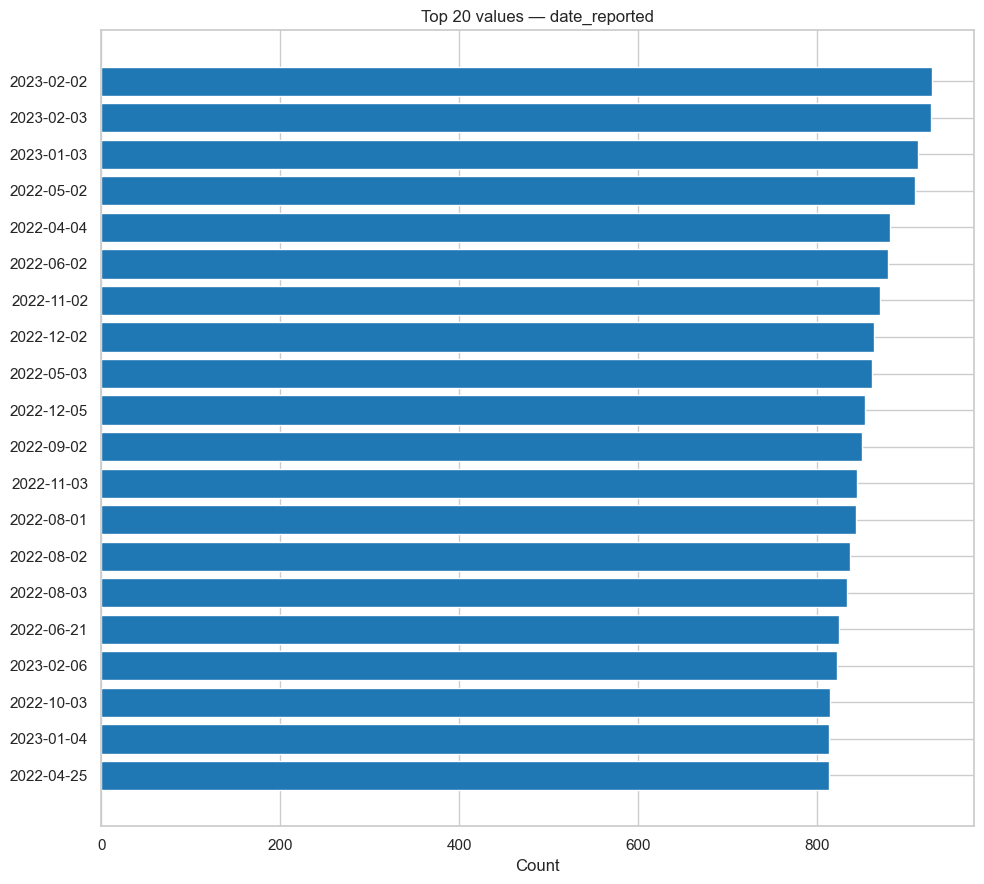

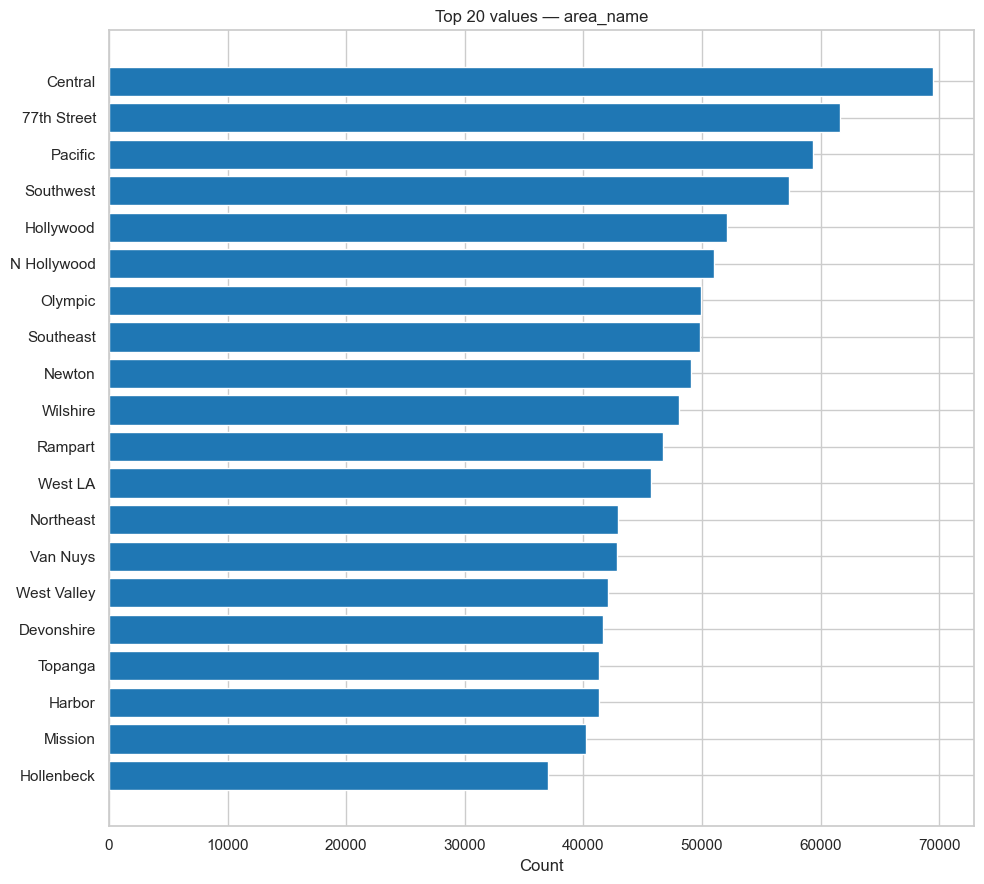

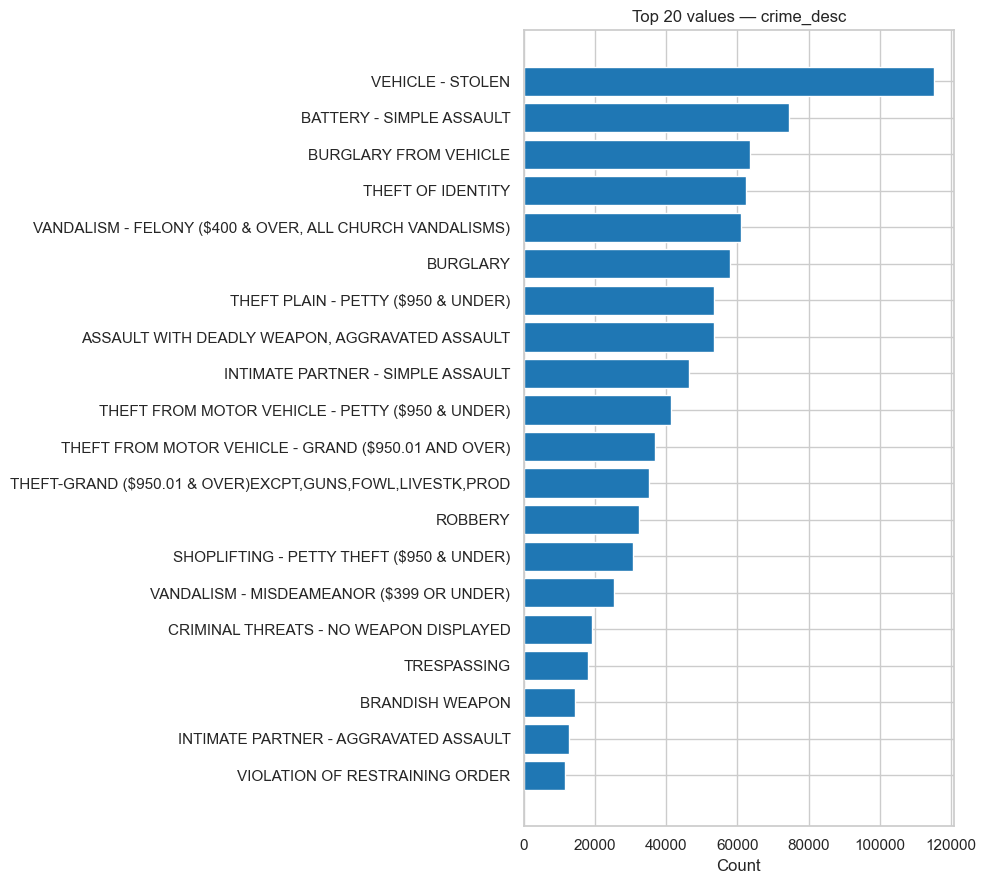

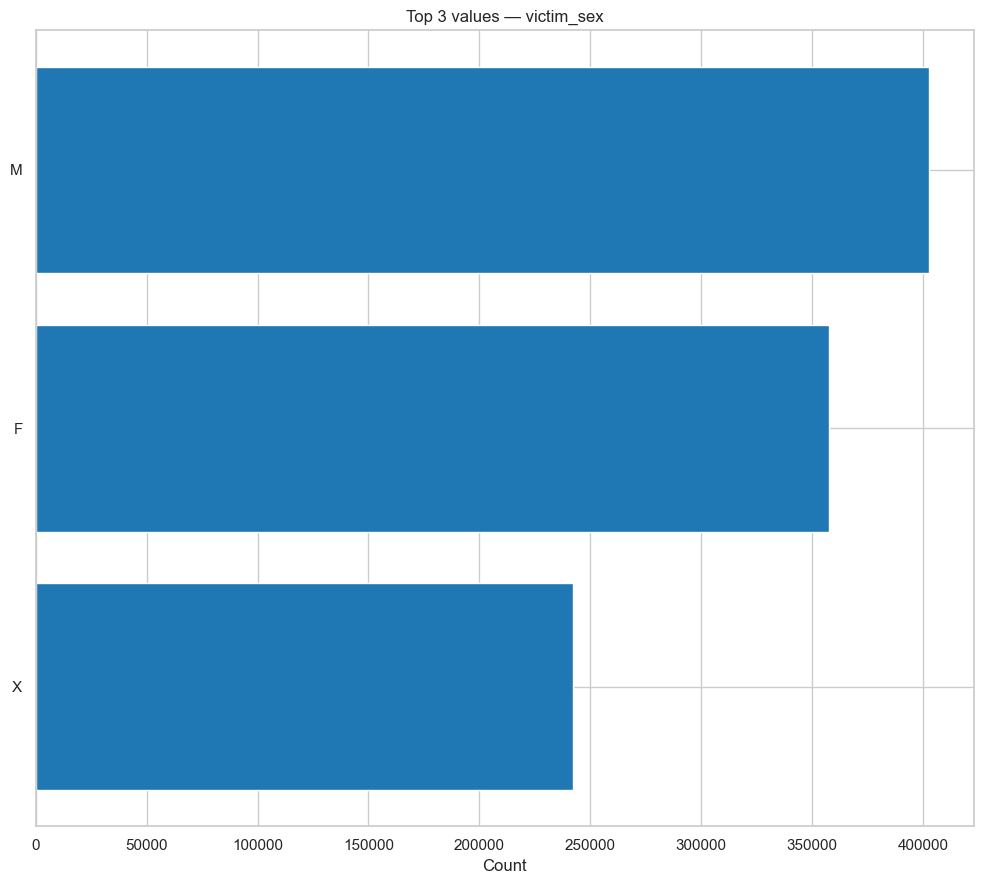

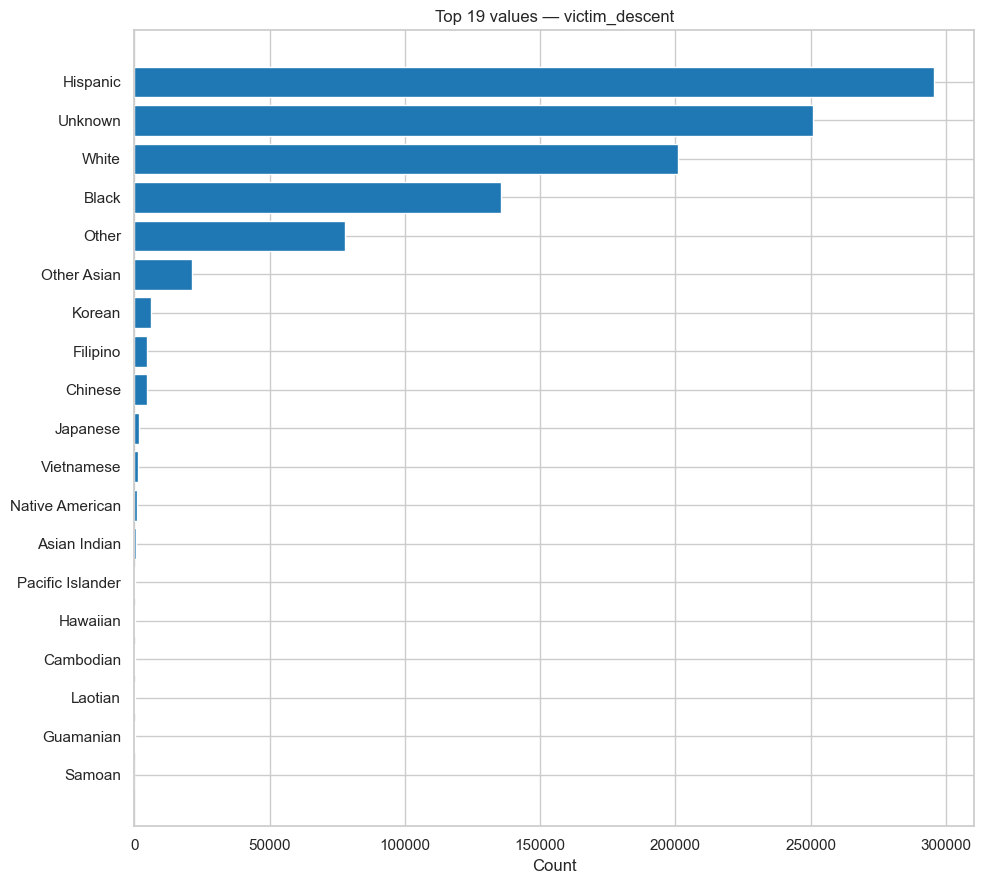

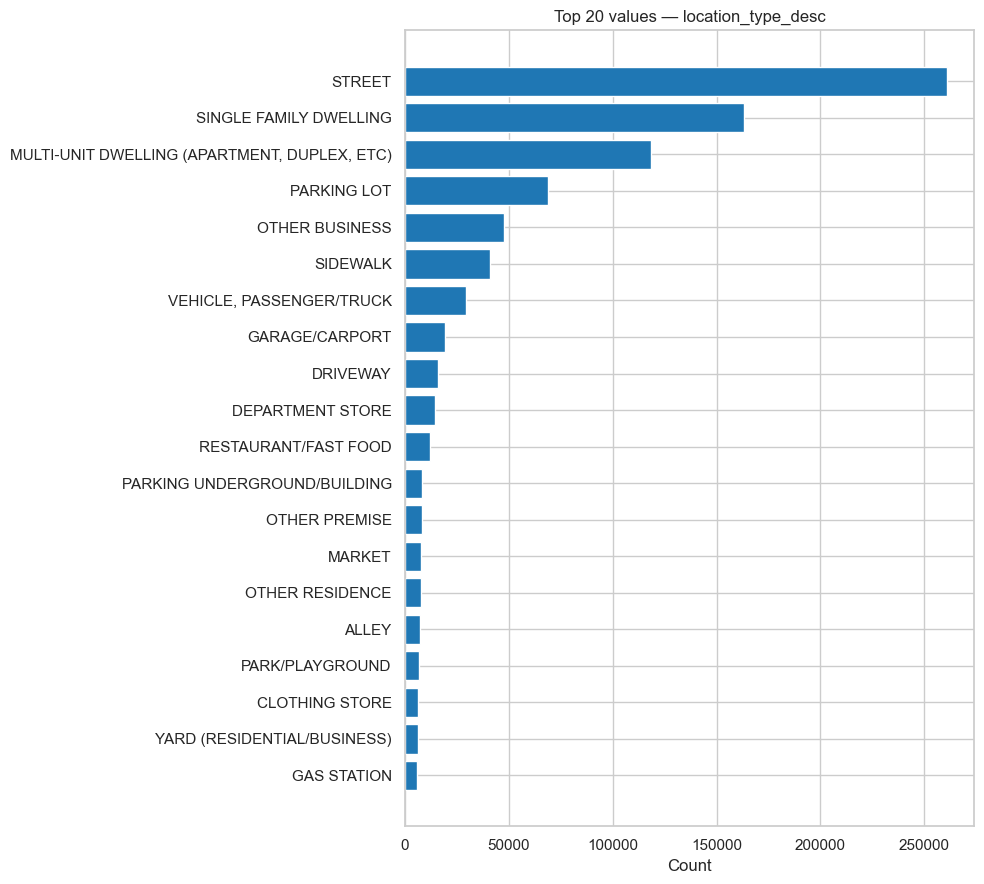

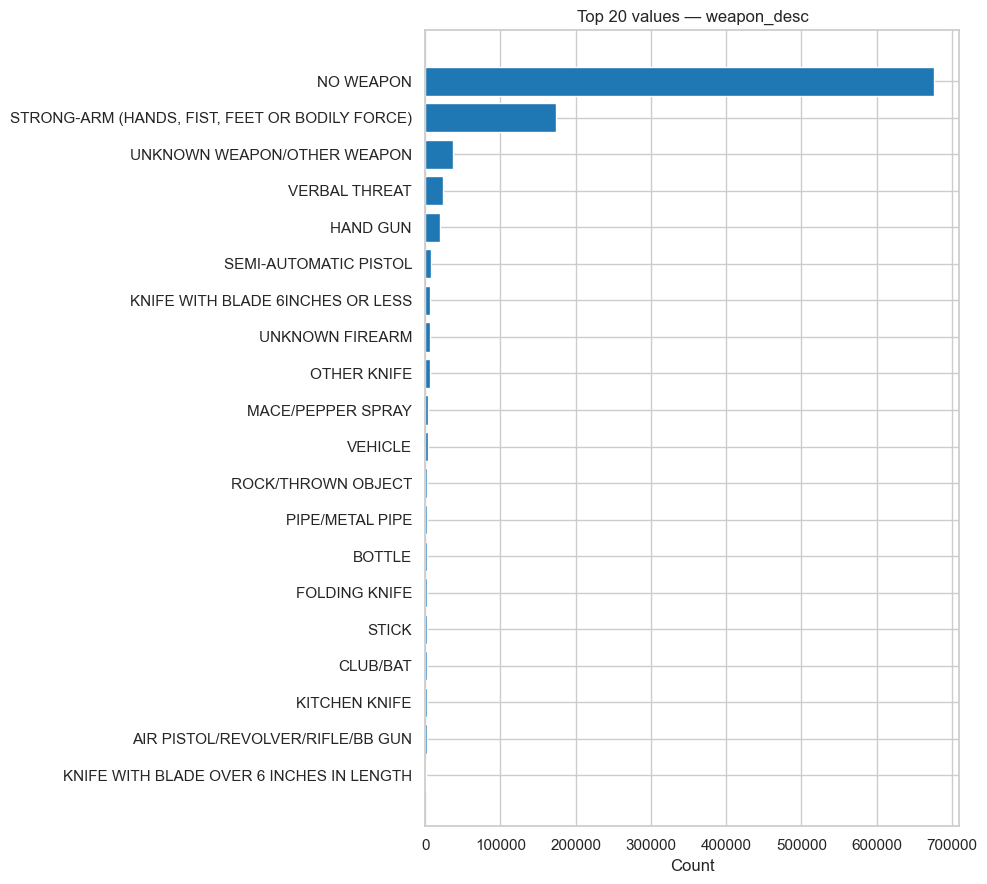

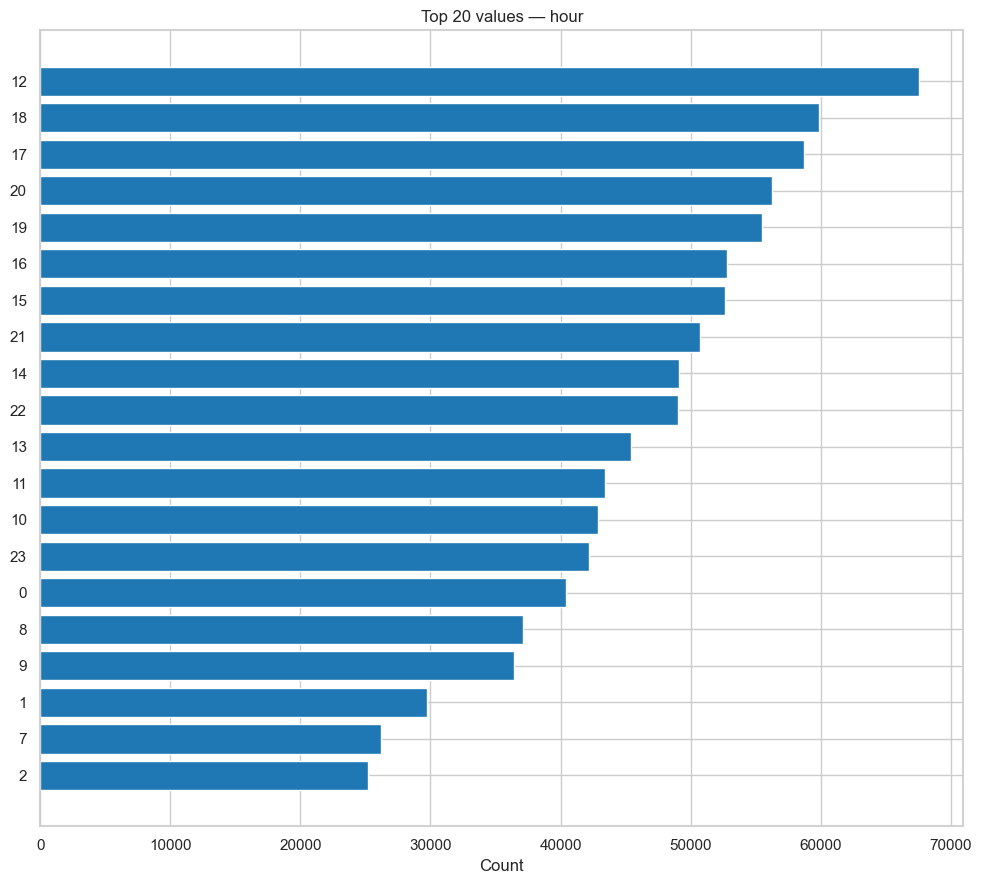

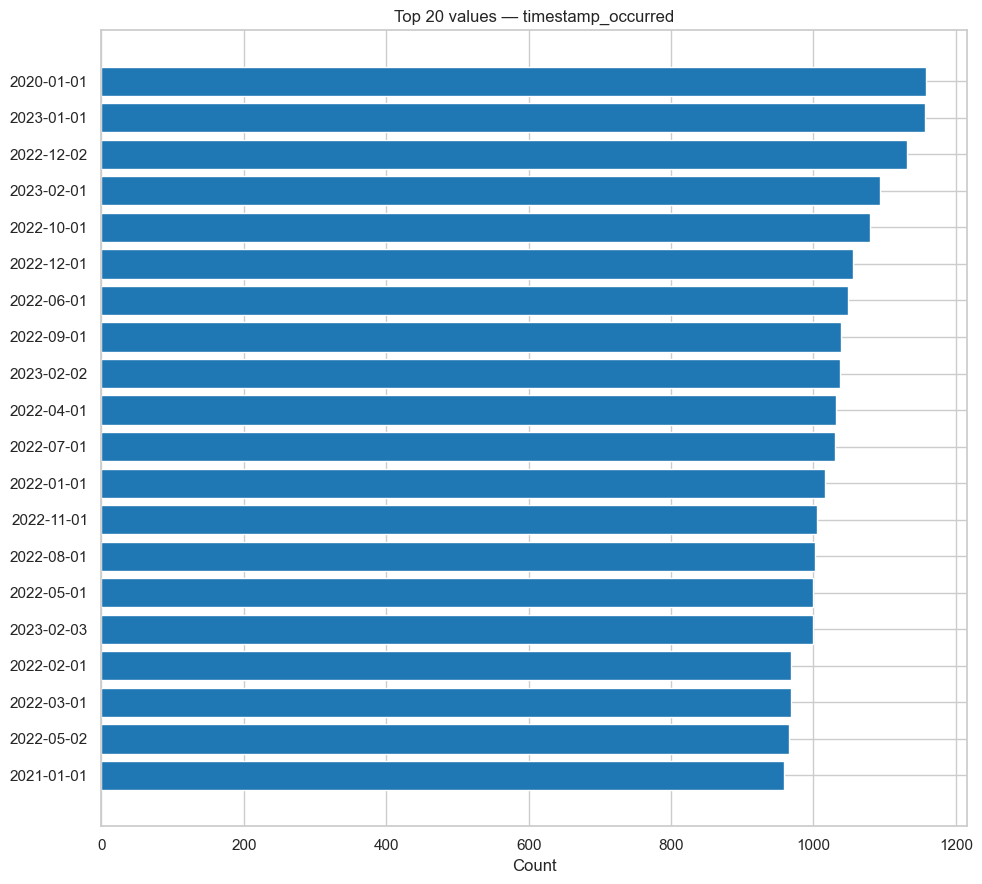

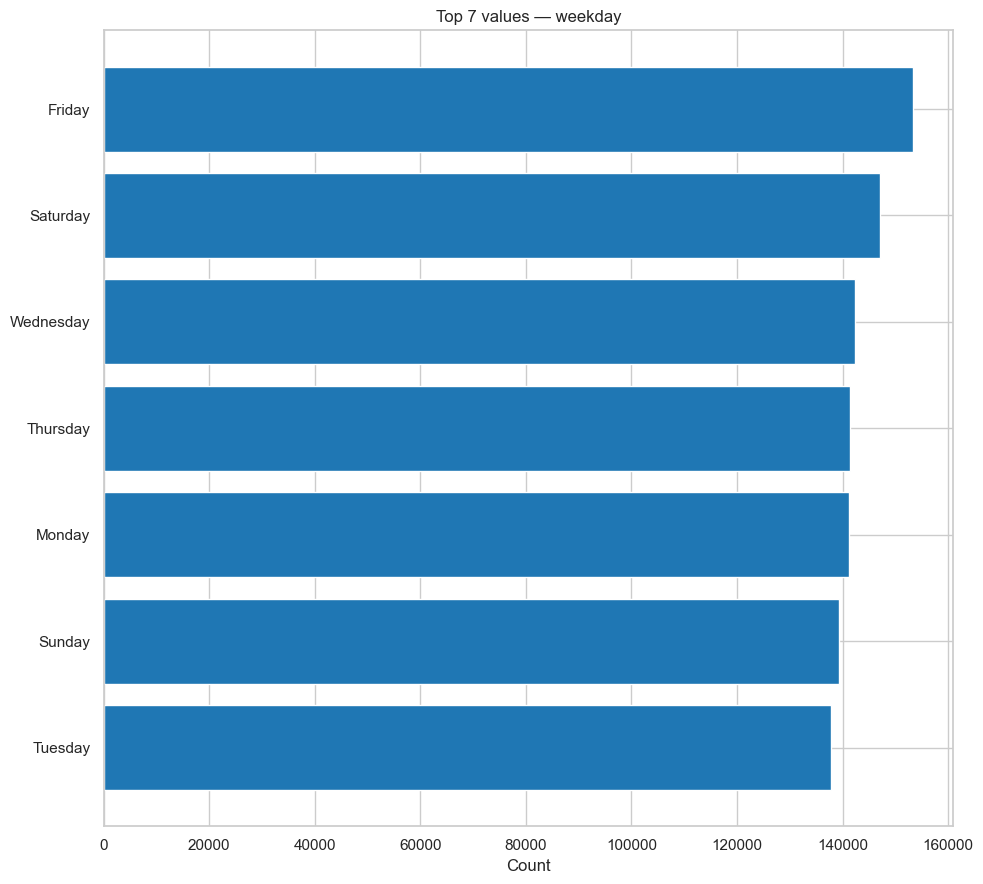

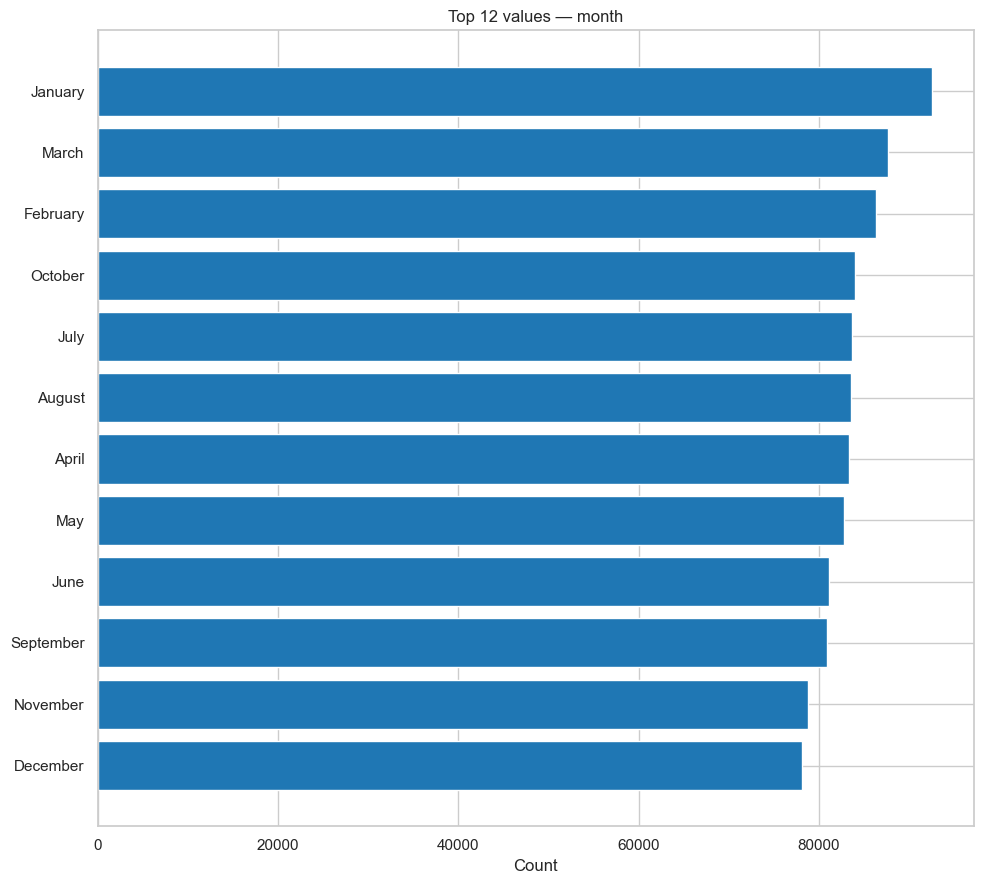

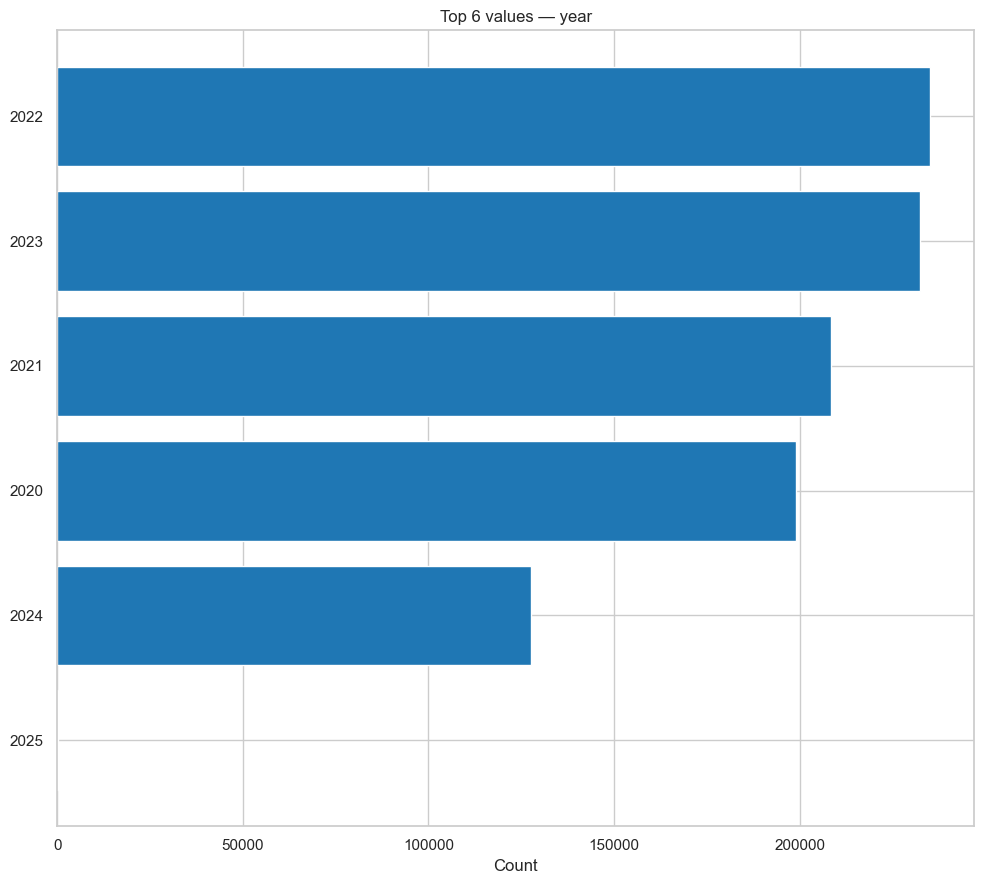

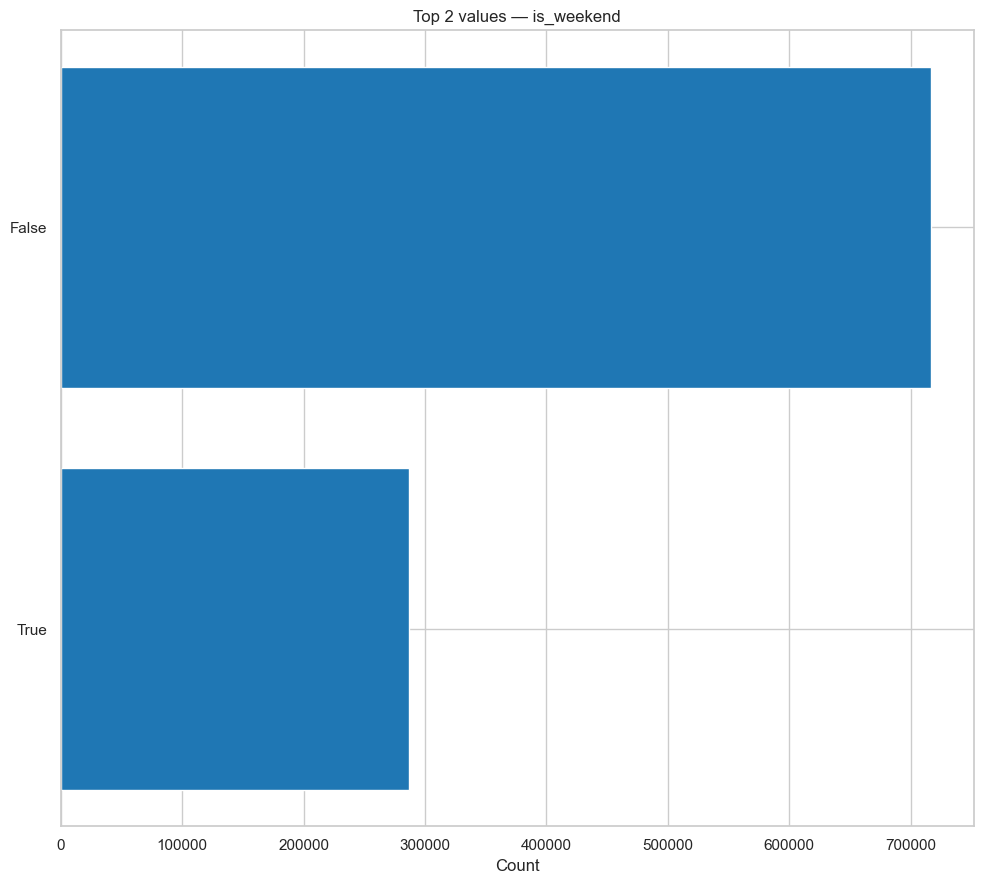

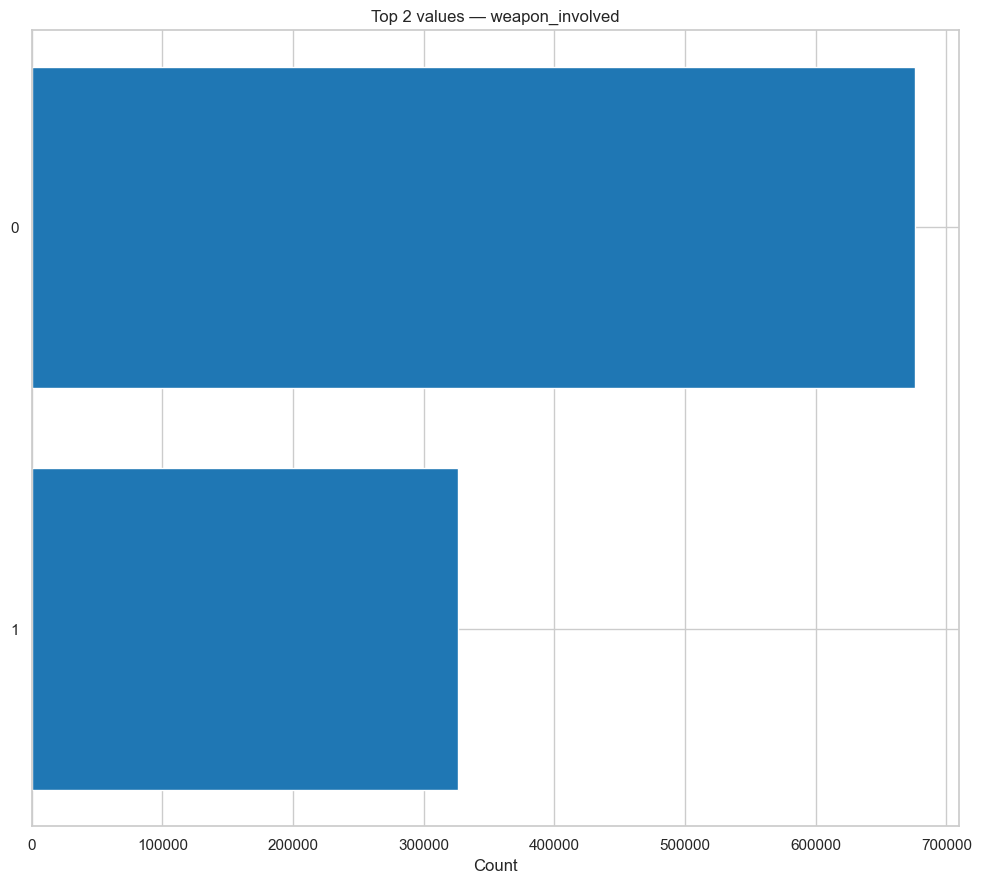

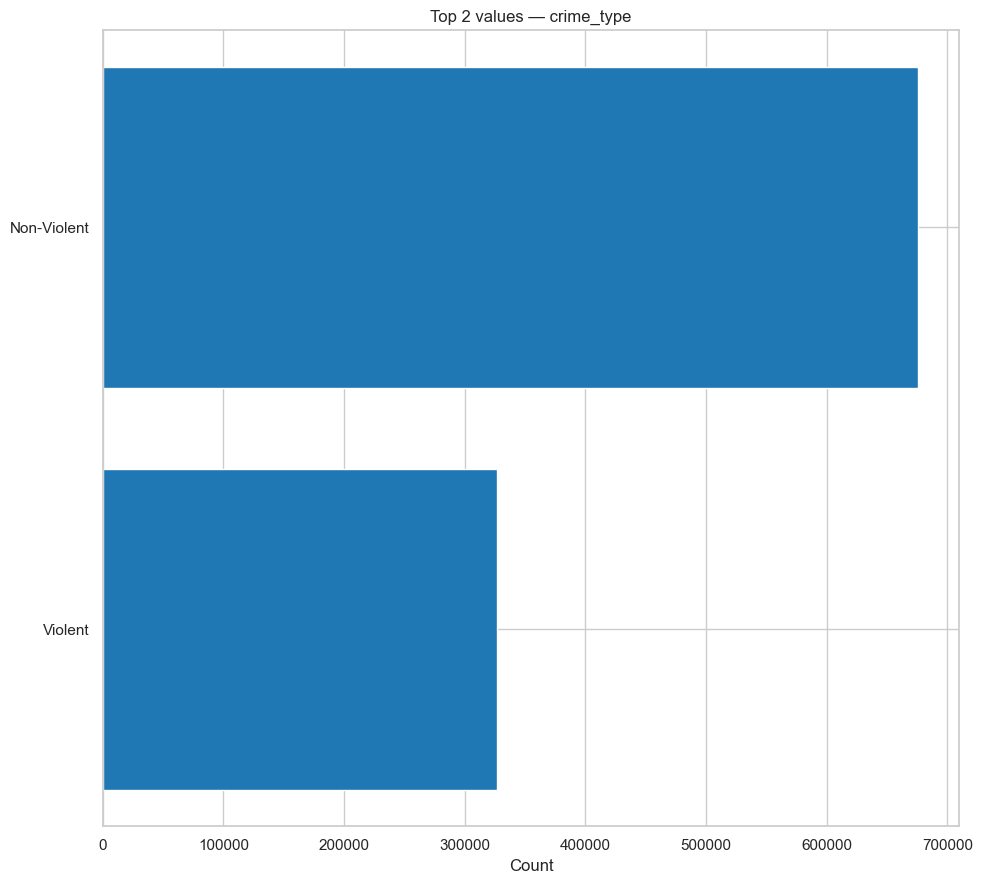

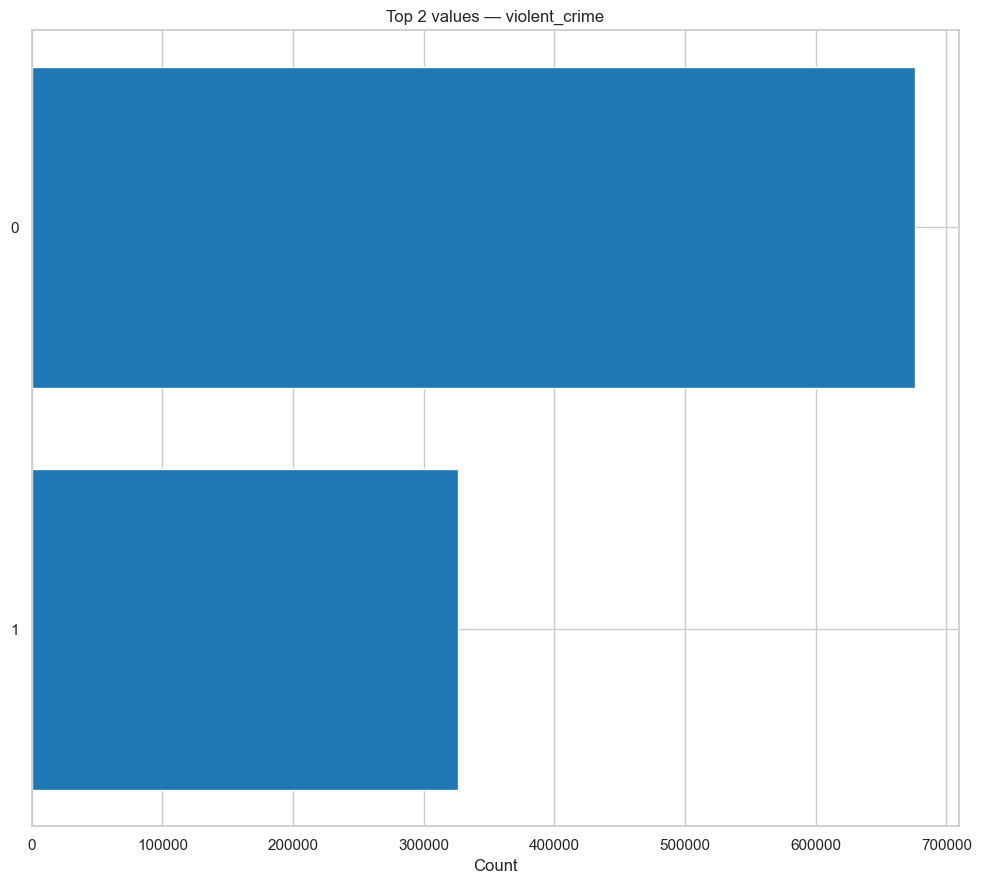

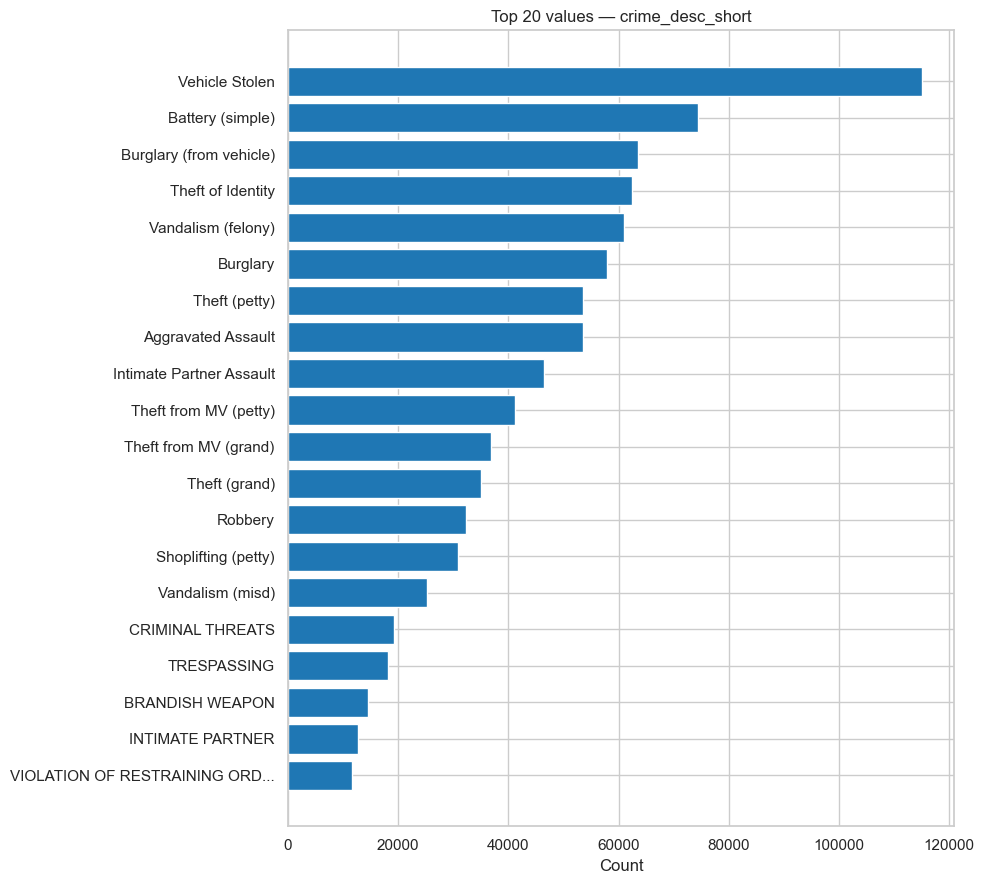

In [61]:
plot_top_frequencies(df)